# Initial Setup

In [1084]:
%load_ext autoreload
%autoreload 2

from random import random
import pandas as pd
import matplotlib
import numpy as np
import csv
import itertools
import pickle as pkl

import time
import datetime
from dateutil.relativedelta import relativedelta
import pandas_market_calendars as mcal

import yfinance as yf
from alpha_vantage.timeseries import TimeSeries

from IPython.display import Audio
sound_file = '../sound/done.mp3'
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics(
    ip,
    require_interaction=True
))
# %load_ext jupyternotify

import pmdarima as pm
from pmdarima.metrics import smape
from sklearn.metrics import mean_squared_error as mse

import prophet

from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# from pathlib import Path
# import os
# current_path = os.getcwd()
# # top = Path(__file__ + '..').resolve()
import sys, os
code_path = '/code'
auth_path = '/auth'
if '..' + code_path not in sys.path:
    sys.path.insert(0, '..' + code_path)
if '..' + auth_path not in sys.path:
    sys.path.insert(0, '..' + auth_path)
current_path = os.getcwd()
sys.path
# sys.path.insert(0, top/ 'code')
# sys.path.insert(0, top/ 'auth')
# sys.path.insert(0, '../code')
# sys.path.insert(0, '../auth')
# sys.path.insert(0, '../')

# arrow = top / 'assets/arrow.png'
# print('source image:', arrow)

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
# plt.style.use('ggplot')
sns.set_theme(style="darkgrid")

%matplotlib inline
font = {'size'   : 14}
matplotlib.rc('font', **font)

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',50)

from functions import *
from Pmdarima_Model import Pmdarima_Model

# only display whole years in figures
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')

from keys import client_id, secret_key, av_key, consumer_key

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

## Get NYSE calendar

In [287]:
NYSE = mcal.get_calendar('NYSE')
early = NYSE.schedule(start_date='2012-07-01', end_date='2012-07-10')
early;

UsageError: Line magic function `%%notify` not found.


## Set up Frequency Variables

### Custom Business Hour

In [304]:
cbh = pd.offsets.CustomBusinessHour(calendar=NYSE, start='05:00', end='21:00')
cbh

<IPython.core.display.Javascript object>

### Custom Business Day

In [298]:
%notify
cbd = pd.offsets.CustomBusinessDay(calendar=NYSE)
cbd

<IPython.core.display.Javascript object>

<CustomBusinessDay>

# YFinance

## Setup / Gather Data

In [5]:
ticker = 'SPY'

In [6]:
# spy_df = yf.download(ticker, start='2018-05-01', end='2021-05-01', progress=False)
# spy_df.index = spy_df.index.rename('date')
# spy_df.columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume']
# spy_df.to_csv('../data/SPY_3Y_CBD.csv')

In [7]:
# spy_df = yf.download(ticker, start='2016-05-01', end='2021-05-01', progress=False)
# spy_df.index = spy_df.index.rename('date')
# spy_df.columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume']
# spy_df.to_csv('../data/SPY_5Y_CBD.csv')

In [8]:
# spy_df = yf.download(ticker, start='2011-05-01', end='2021-05-01', progress=False)
# spy_df.index = spy_df.index.rename('date')
# spy_df.columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume']
# spy_df.to_csv('../data/SPY_10Y_CBD.csv')

## Load Data from File

### 3Y

In [9]:
spy_df_3Y = pd.read_csv('../data/SPY_3Y_CBD.csv', index_col='date')
spy_df_3Y.index = pd.to_datetime(spy_df_3Y.index)

### 5Y

In [10]:
spy_df_5Y = pd.read_csv('../data/SPY_5Y_CBD.csv', index_col='date')
spy_df_5Y.index = pd.to_datetime(spy_df_5Y.index)

### 10Y

In [11]:
spy_df_10Y = pd.read_csv('../data/SPY_10Y_CBD.csv', index_col='date')
spy_df_10Y.index = pd.to_datetime(spy_df_10Y.index)

## Data Preparation

### EDA

In [12]:
spy_df_5Y

,open,high,low,close,adj_close,volume
date,,,,,,
2016-05-02,206.919998,208.179993,206.410004,207.970001,189.178101,62188000
2016-05-03,206.520004,206.800003,205.279999,206.160004,187.531647,106422100
2016-05-04,204.990005,205.850006,204.419998,205.009995,186.485535,92243800
2016-05-05,205.559998,205.979996,204.470001,204.970001,186.449203,67619200
2016-05-06,204.059998,205.770004,203.880005,205.720001,187.131424,89315000
...,...,...,...,...,...,...
2021-04-26,417.440002,418.220001,416.809998,417.609985,417.609985,52182400
2021-04-27,417.929993,418.140015,416.299988,417.519989,417.519989,51303100
2021-04-28,417.809998,419.010010,416.899994,417.399994,417.399994,51238900


In [13]:
spy_df_3Y.isna().sum()

open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64

### Set up Frequency

In [14]:
spy_df_3Y = spy_df_3Y.asfreq(cbd)
spy_df_5Y = spy_df_5Y.asfreq(cbd)
spy_df_10Y = spy_df_10Y.asfreq(cbd)

In [15]:
spy_df_5Y.isna().sum()

open         46
high         46
low          46
close        46
adj_close    46
volume       46
dtype: int64

### Impute Missing Values

In [353]:
spy_df_3Y = spy_df_3Y.interpolate()
spy_df_5Y = spy_df_5Y.interpolate()
spy_df_10Y = spy_df_10Y.interpolate()

### Create Time Series for `Close`, `Volume`

In [404]:
df_full_3Y_close = spy_df_3Y.close
df_full_3Y_vol = spy_df_3Y.volume
df_full_5Y_close = spy_df_5Y.close
df_full_5Y_vol = spy_df_5Y.volume
df_full_10Y_close = spy_df_10Y.close
df_full_10Y_vol = spy_df_10Y.volume

In [294]:
df_full_5Y_close, df_full_5Y_vol

(date
 2016-05-02    207.970001
 2016-05-03    206.160004
 2016-05-04    205.009995
 2016-05-05    204.970001
 2016-05-06    205.720001
                  ...    
 2021-04-26    417.609985
 2021-04-27    417.519989
 2021-04-28    417.399994
 2021-04-29    420.059998
 2021-04-30    417.339996
 Freq: C, Name: close, Length: 1305, dtype: float64,
 date
 2016-05-02     62188000.0
 2016-05-03    106422100.0
 2016-05-04     92243800.0
 2016-05-05     67619200.0
 2016-05-06     89315000.0
                  ...     
 2021-04-26     52182400.0
 2021-04-27     51303100.0
 2021-04-28     51238900.0
 2021-04-29     78311900.0
 2021-04-30     77175100.0
 Freq: C, Name: volume, Length: 1305, dtype: float64)

## Plot PACF

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning:

invalid value encountered in sqrt



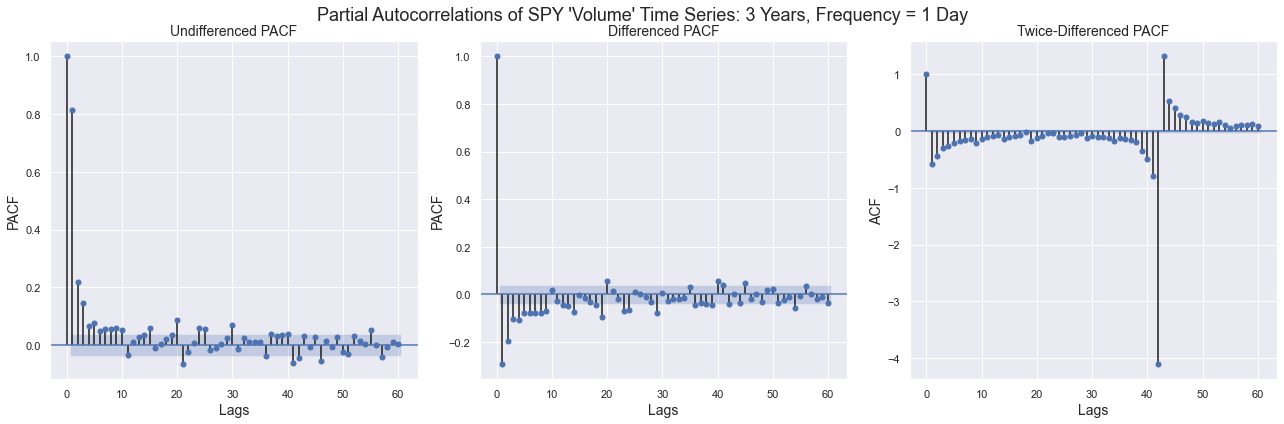

In [351]:
plot_pacf_with_diff(df_full_10Y_vol, 'SPY \'Volume\'', 3, 'years', '1 Day', lags=60)

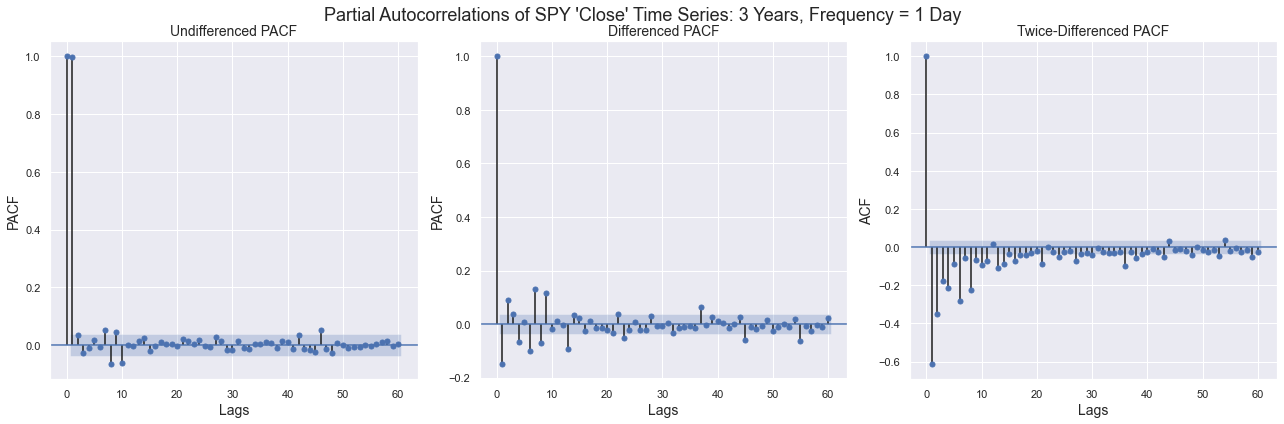

In [352]:
plot_pacf_with_diff(df_full_10Y_close.interpolate(), 'SPY \'Close\'', 3, 'years', '1 Day', lags=60)

## Plot ACF

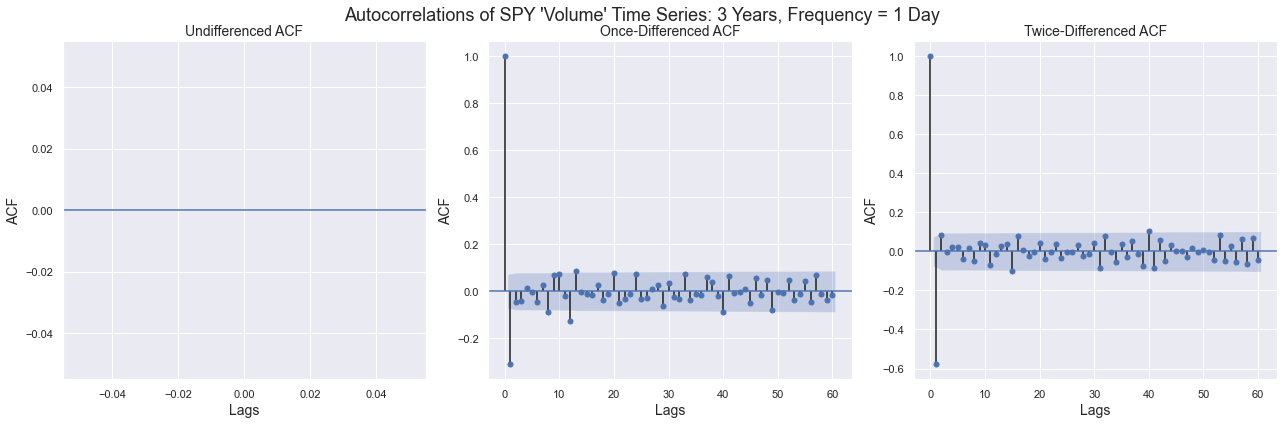

In [21]:
plot_acf_with_diff(df_full_3Y_vol, 'SPY \'Volume\'', 3, 'years', '1 Day', lags=60)

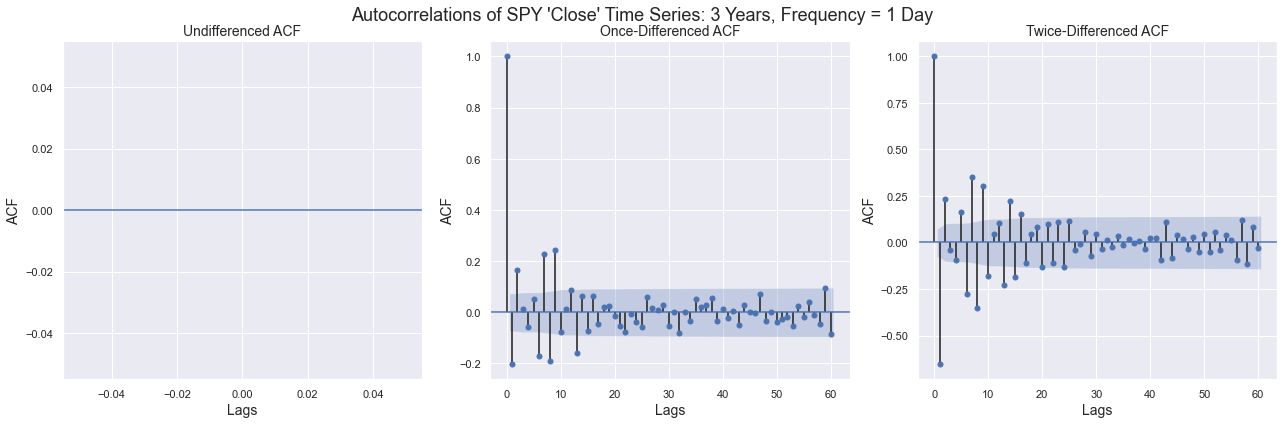

In [22]:
plot_acf_with_diff(df_full_3Y_close, 'SPY \'Close\'', 3, 'years', '1 Day', lags=60)

## Plot Seasonal Decomposition

### 3 Years, Freq = Custom Business Day, Yearly Seasonality

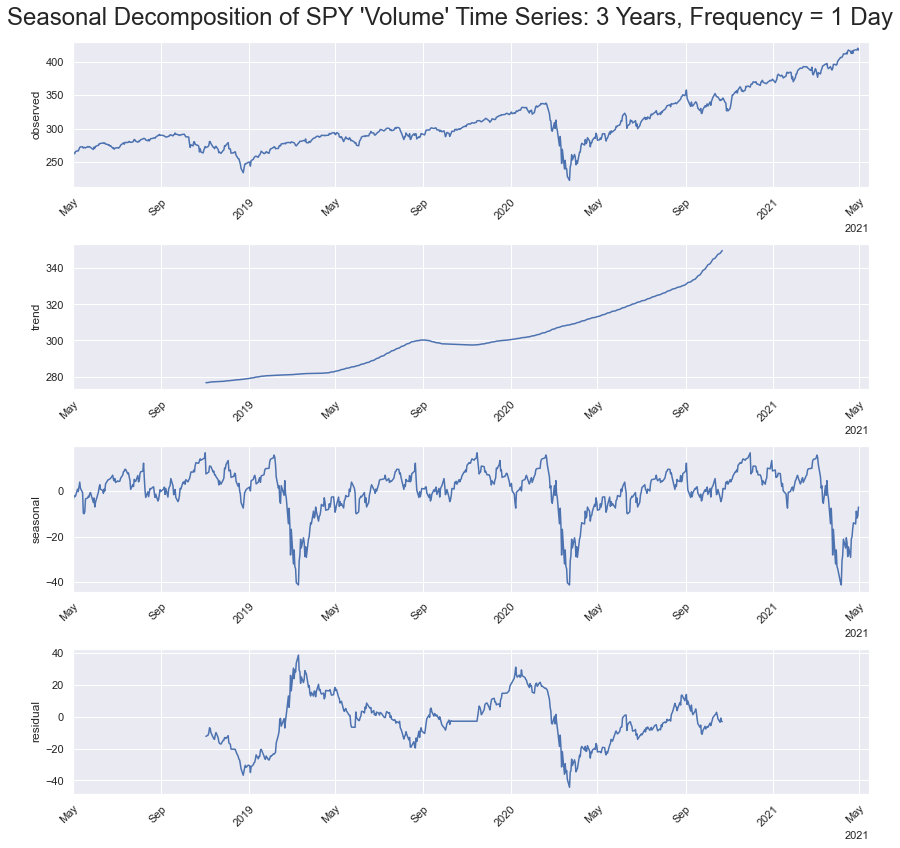

In [23]:
plot_seasonal_decomposition(df_full_3Y_close.dropna(), 'SPY \'Volume\'', 3, 'years', '1 Day', 261)

### 5 Years, Freq = Custom Business Day, Yearly Seasonality

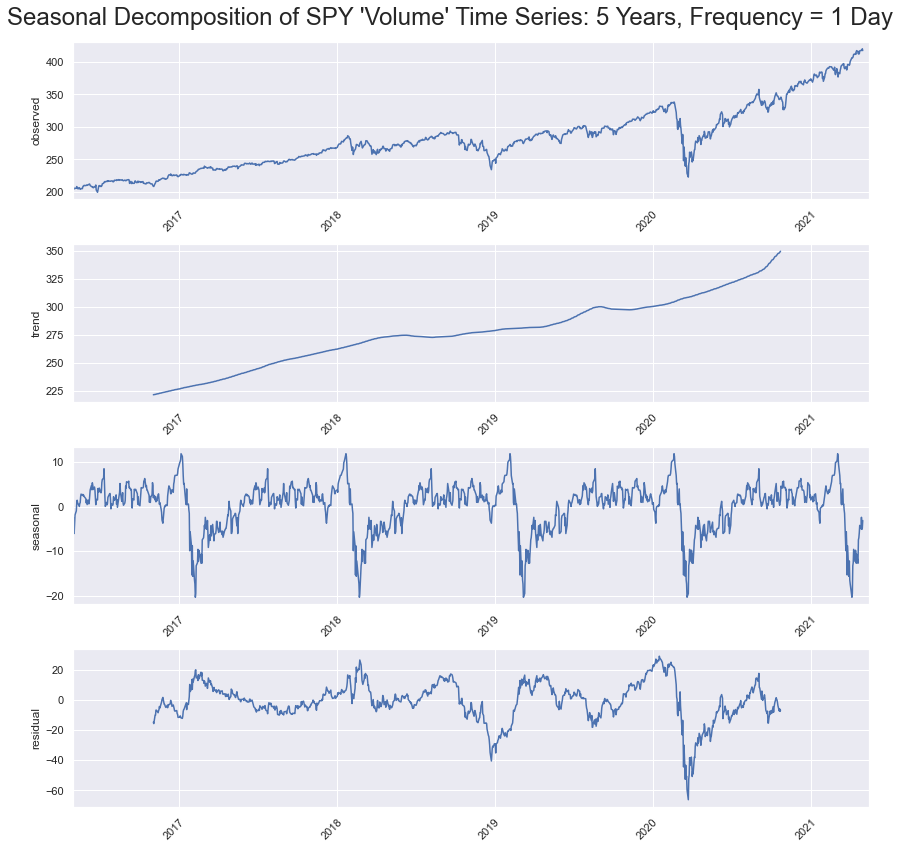

In [24]:
plot_seasonal_decomposition(df_full_5Y_close.dropna(), 'SPY \'Volume\'', 5, 'years', '1 Day', 261)

### 10 Years, Freq = Custom Business Day, Yearly Seasonality

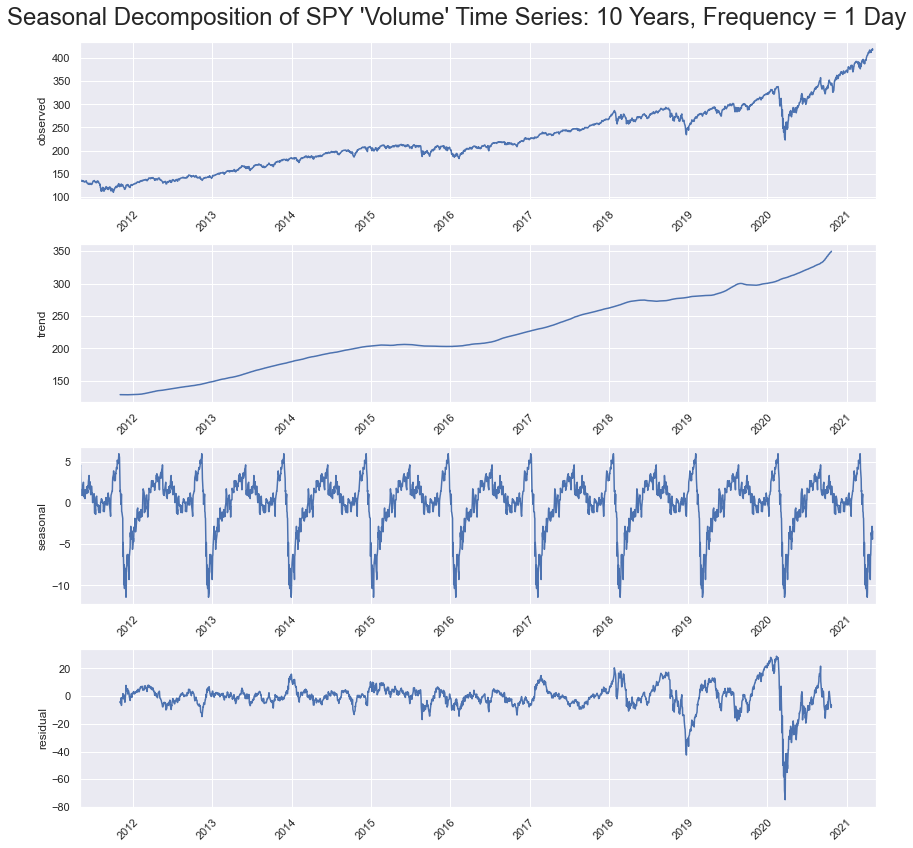

In [25]:
plot_seasonal_decomposition(df_full_10Y_close.dropna(), 'SPY \'Volume\'', 10, 'years', '1 Day', 261)

# Modeling

## Last 3 Years, 1 Day

In [550]:
np.asarray([-0.19366851,  0.19684047, 16.60013925])

array([-0.19366851,  0.19684047, 16.60013925])

In [536]:
# df_train, df_test, vol_train, vol_test = pdarima_fit_predict(df_full_3Y_close, df_full_5Y_vol, 'SPY \'Close\'', 'SPY \'Volume\'',
#                                                              n=3, period='years', freq='1 Day', seas=261,
#                                                              train_size=80, impute=1, verbose=1, extra=1)

### Using Custom Class `Pmdarima_Model`

In [786]:
pam_3Y = Pmdarima_Model(df_full_3Y_close, df_full_3Y_vol, 'SPY \'Close\'', 'SPY \'Volume\'',
               n=3, period='years', freq='1 Day', seas=261, fit_seas=False,
               train_size=80, impute=0, verbose=1,
               date=1, fourier=1, box=0, log=0, gridsearch=0)

Successfully created instance of Class Pmdarima_Model.


Starting AutoARIMA...
Endogenous data set diffs to use: 1


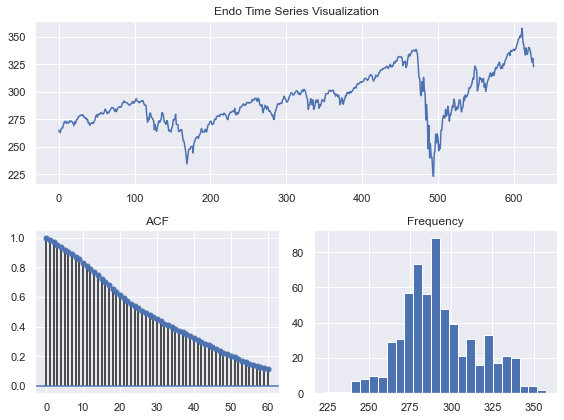

Using DateFeaturizer.
Using FourierFeaturizer.
Parameters for Pipeline: 
[('date', DateFeaturizer(column_name='date')), ('fourier', FourierFeaturizer(k=4, m=261)), ('arima', AutoARIMA(d=1, maxiter=200, seasonal=False, trace=3))]

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3515.502, Time=2.04 sec
First viable model found (3515.502)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3561.981, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3527.004, Time=1.54 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3535.806, Time=1.89 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3560.122, Time=0.66 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3515.183, Time=1.41 sec
New best model found (3515.183 < 3515.502)
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3513.725, Time=0.98 sec
New best model found (3513.725 < 3515.183)
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3514.781, Time=1.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3523.811, Time=2.49 sec
 ARIMA(1,1,

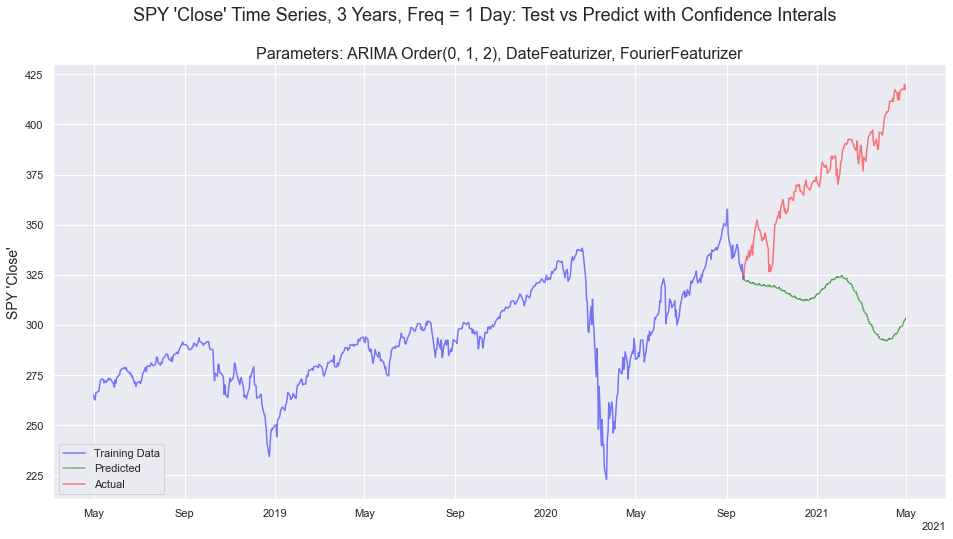

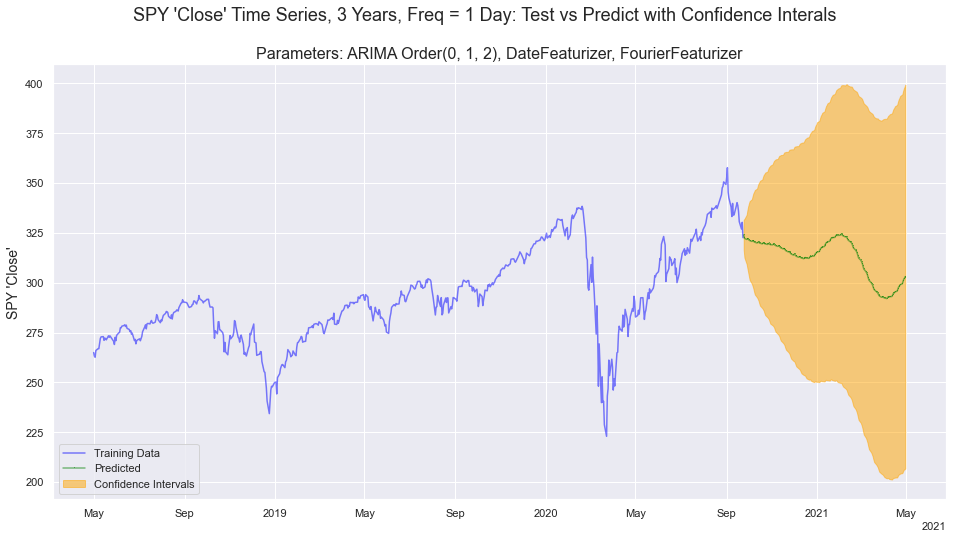

In [787]:
endo_pipe, exog_pipe = pam_3Y.run_auto_pipeline(en=True, ex=False, visualize=True)
# Audio(sound_file, autoplay=True)

Starting Step-Wise Cross-Validation...
Iteratively making predictions on Endo Time Series and updating model, beginning with first index of y_test ................................................................................................................................................................ Done.
Test AIC: 4356.93
Test RMSE: 3.57
This is 1.22% of the avg observed value.
Test SMAPE: 0.74%



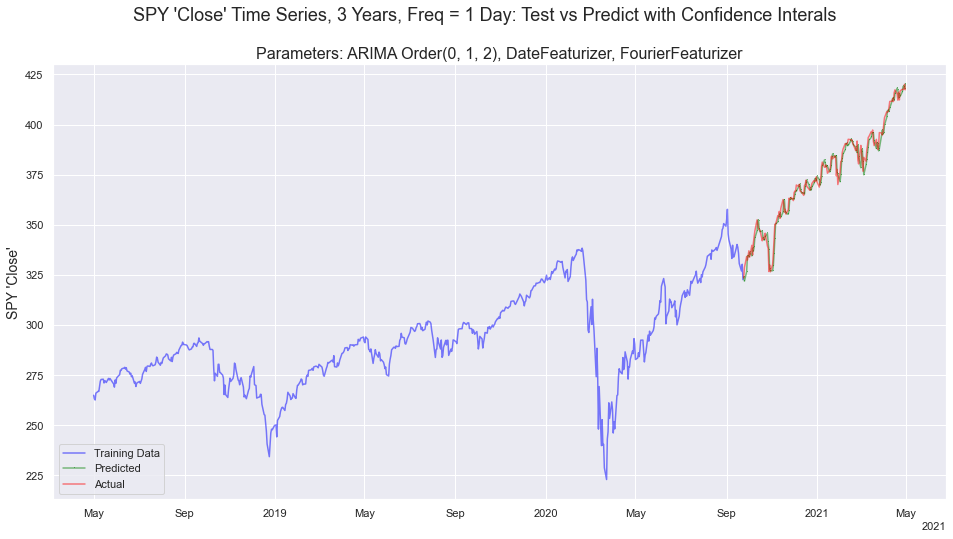

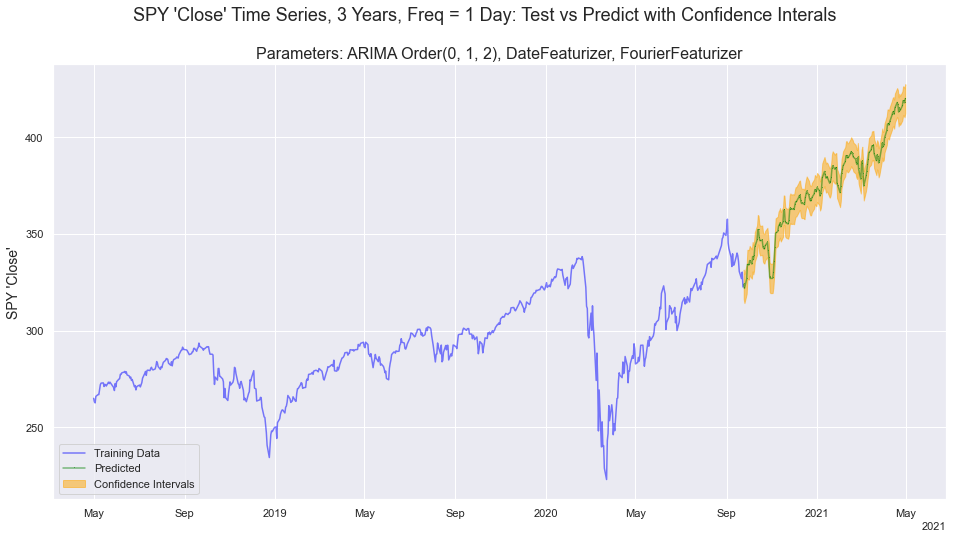

In [788]:
pam_3Y.run_stepwise_cv(en=True, ex=False, dynamic=False, visualize=True)

Starting Step-Wise Cross-Validation...
Iteratively making predictions on Endo Time Series and updating model dynamically with forecasted values, beginning with first index of y_test ................................................................................................................................................................ Done.
Test AIC: 5050.62
Test RMSE: 63.39
This is 21.68% of the avg observed value.
Test SMAPE: 14.87%



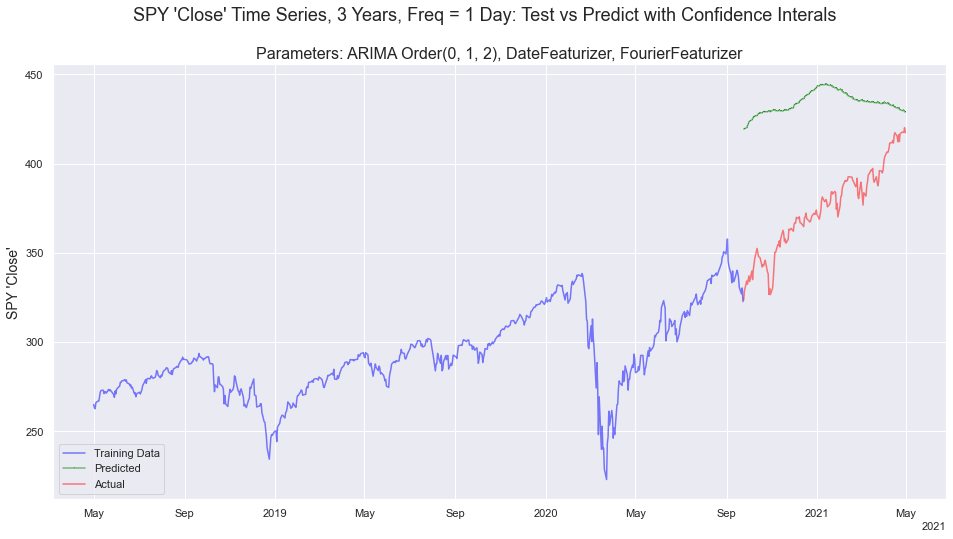

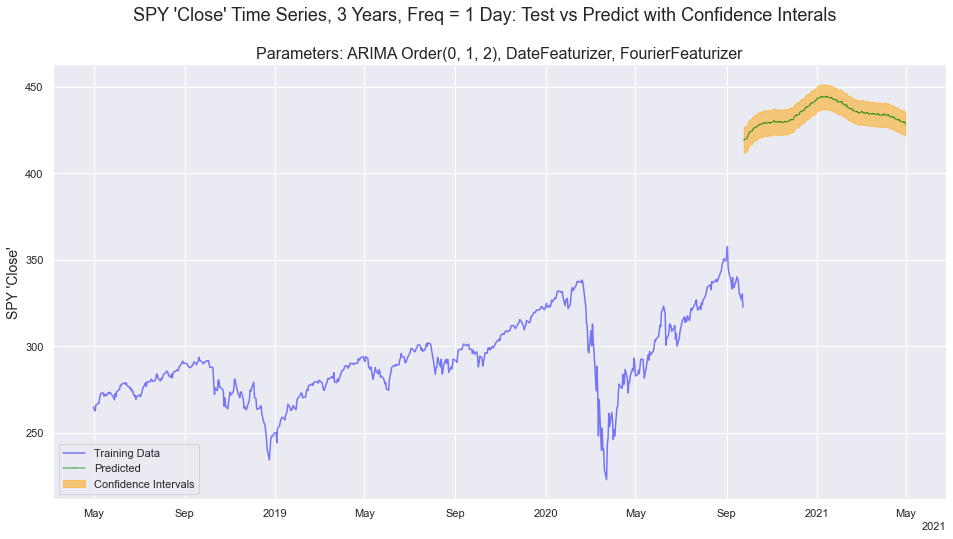

In [789]:
pam_3Y.run_stepwise_cv(en=True, ex=False, dynamic=True, visualize=True)
Audio(sound_file, autoplay=True)

### Forecasting into the future

In [765]:
today = datetime.date.today()
today

datetime.date(2021, 5, 3)

In [778]:
new_dates = pd.date_range(start=today, periods=5, freq=cbd)
new_dates

DatetimeIndex(['2021-05-03', '2021-05-04', '2021-05-05', '2021-05-06',
               '2021-05-07'],
              dtype='datetime64[ns]', freq='C')

In [781]:
index_fc = range(pam_3Y.length,pam_3Y.length+5)

In [782]:
new_dates_df = pd.DataFrame(new_dates, index=index_fc, columns=['date'])
new_dates_df

,date
784,2021-05-03
785,2021-05-04
786,2021-05-05
787,2021-05-06
788,2021-05-07


#### Closing Prices Only

In [790]:
pam_3Y_close = endo_pipe

In [792]:
close_hat, close_conf_ints = pam_3Y_close.predict(X=new_dates_df, return_conf_int=True)
close_hat

array([429.33619964, 429.47002317, 429.4070118 , 429.09536043,
       428.91725286])

#### Volume --> Close

In [764]:
pam_3Y_vol = exog_pipe

In [783]:
vol_hat, vol_conf_ints = pam_3Y_vol.predict(X=new_dates_df, return_conf_int=True)
vol_hat

In [838]:
vol_hat_df = pd.DataFrame(vol_hat, index=index_fc, columns=['volume'])
vol_hat_df = vol_hat_df.join(new_dates_df)
vol_hat_df

,volume,date
784,7.350269e+07,2021-05-03
785,7.365760e+07,2021-05-04
786,7.702139e+07,2021-05-05
787,7.869629e+07,2021-05-06
788,8.503183e+07,2021-05-07


In [795]:
date_feat = pm.preprocessing.DateFeaturizer(
    column_name="date",  # the name of the date feature in the X matrix
    with_day_of_week=True,
    with_day_of_month=True)
_, X_train_feats = date_feat.fit_transform(y_train, X_train)
full_3Y_pipe = pipeline.Pipeline([
    ('date', date_feat),
    ("fourier", pm.preprocessing.FourierFeaturizer(m=261, k=4)),
    ('arima', pm.arima.AutoARIMA(d=1,
                                 trace=3,
                                 stepwise=True,
                                 suppress_warnings=True,
                                 seasonal=False))
])

In [842]:
vol_3Y_df = pd.DataFrame(df_full_3Y_vol).reset_index()

In [807]:
full_3Y_pipe.fit(df_full_3Y_close, vol_3Y_df)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4224.679, Time=1.84 sec
First viable model found (4224.679)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4256.333, Time=1.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4227.118, Time=1.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4232.836, Time=1.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8691.882, Time=0.91 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4228.703, Time=1.38 sec


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1886: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8506.711, Time=1.27 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4210.299, Time=1.64 sec
New best model found (4210.299 < 4224.679)
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4226.254, Time=1.50 sec


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1886: RuntimeWarning:

divide by zero encountered in reciprocal

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1893: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=4270.327, Time=1.66 sec


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1886: RuntimeWarning:

divide by zero encountered in reciprocal

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1893: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4270.763, Time=1.59 sec


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1886: RuntimeWarning:

divide by zero encountered in reciprocal

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1893: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4268.454, Time=1.69 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4217.669, Time=1.94 sec


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1886: RuntimeWarning:

divide by zero encountered in reciprocal

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1893: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=4274.121, Time=1.82 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=4209.933, Time=1.55 sec
New best model found (4209.933 < 4210.299)
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4225.078, Time=1.41 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=4226.818, Time=1.72 sec


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1886: RuntimeWarning:

divide by zero encountered in reciprocal

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1893: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(4,1,2)(0,0,0)[0]             : AIC=4270.400, Time=1.81 sec


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1886: RuntimeWarning:

divide by zero encountered in reciprocal

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1893: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(3,1,3)(0,0,0)[0]             : AIC=4270.982, Time=1.71 sec


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1886: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(2,1,1)(0,0,0)[0]             : AIC=25465.105, Time=1.42 sec


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1886: RuntimeWarning:

divide by zero encountered in reciprocal

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1893: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4268.734, Time=1.70 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=4218.925, Time=1.78 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=4274.415, Time=1.68 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0]          
Total fit time: 35.373 seconds


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1886: RuntimeWarning:

divide by zero encountered in reciprocal

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1893: RuntimeWarning:

divide by zero encountered in reciprocal



Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima', AutoARIMA(d=1, seasonal=False, trace=3))])

In [843]:
close_vol_hat, close_vol_conf_ints = full_3Y_pipe.predict(X=vol_hat_df, return_conf_int=True)
close_vol_hat

array([418.31021967, 419.29110932, 419.29656498, 420.34162935,
       420.09620826])

#### Plot

In [1045]:
import mplfinance as mpl
import matplotlib.dates as mdates

In [957]:
new_dates_df.date.values

array(['2021-05-03T00:00:00.000000000', '2021-05-04T00:00:00.000000000',
       '2021-05-05T00:00:00.000000000', '2021-05-06T00:00:00.000000000',
       '2021-05-07T00:00:00.000000000'], dtype='datetime64[ns]')

In [960]:
new_fc_df = pd.DataFrame(zip(new_dates_df.date.values,close_vol_hat), columns=['date','close'])
new_fc_df.set_index('date', inplace=True)

In [961]:
new_fc_df

,close
date,
2021-05-03,418.310220
2021-05-04,419.291109
2021-05-05,419.296565
2021-05-06,420.341629
2021-05-07,420.096208


In [962]:
spy_df_3Y_fc = spy_df_3Y.append(new_fc_df)

In [1047]:
class CustomFormatter(FuncFormatter):
    def __init__(self, dates, fmt='%Y-%m-%d'):
        self.dates = dates
        self.fmt = fmt

    def __call__(self, x, pos=0):
        'Return the label for time x at position pos'
        ind = int(np.round(x))
        if ind >= len(self.dates) or ind < 0:
            return ''

        return mdates.num2date(self.dates[ind]).strftime(self.fmt)

In [1033]:
# days = mdates.DayLocator()
# days_fmt = mdates.DateFormatter('%Y-%B-%d')

Text(0.5, 0.98, "SPY 'Close' Time Series, 3 Years, Freq = 1 Day: Historical vs Forecast with Confidence Interals\n")

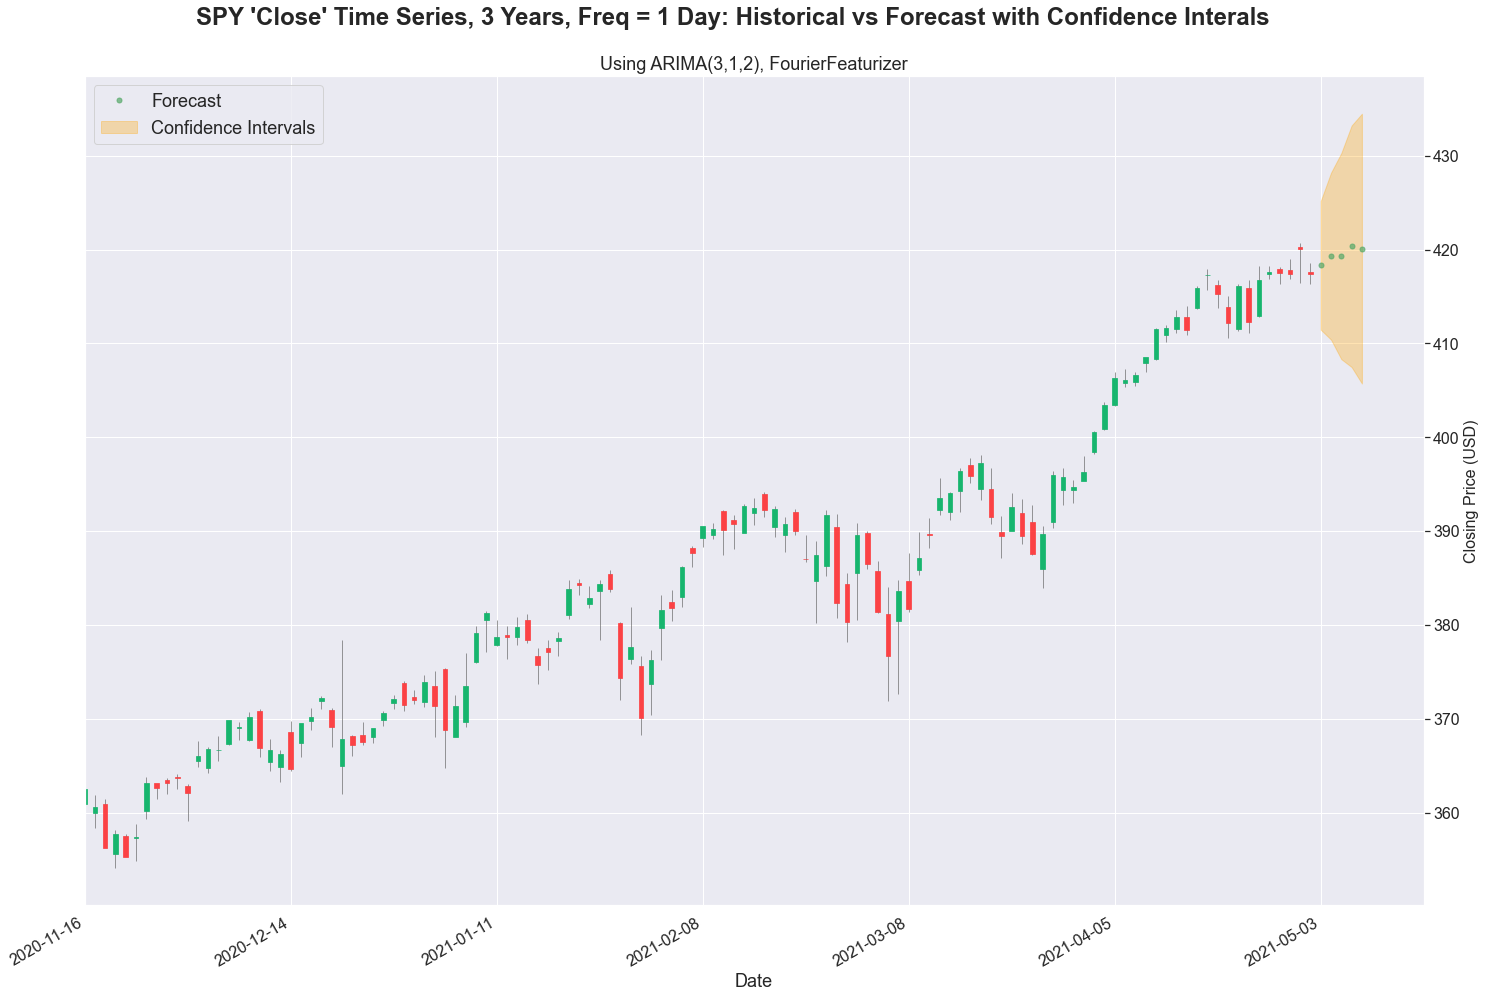

In [1086]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(24, 16))
# fig = mpl.figure()
mpl.plot(spy_df_3Y[-120:],
         type='candle',
#          ylabel='Closing Price (USD)',
         style="yahoo",
#          volume=True,
#          figscale=2,
         ax=ax,
#          title='Using ARIMA(3,1,2), FourierFeaturizer'
         )
ax.plot(range(120,125), close_vol_hat, 'g.', markersize=10, alpha=0.7, label='Forecast')
conf_int = np.asarray(close_vol_conf_ints)
ax.fill_between(range(120,125),
         conf_int[:, 0], conf_int[:, 1],
         alpha=0.3, color='orange',
         label="Confidence Intervals")
ax.set_xlim(0, 130)
ax.set_ylabel('Closing Price (USD)', size=16)
ax.set_title('Using ARIMA(3,1,2), FourierFeaturizer', size=18)
# xfmt = mdates.DateFormatter('%Y-%M-%d')
# ax.xaxis.set_major_formatter(xfmt)
# ax.xaxis.set_major_locator(days)
# ax.xaxis.set_major_formatter(days_fmt)
# ax.set_xticklabels(dates_dt)
# formatter = CustomFormatter(spy_df_3Y_fc)
# ax.xaxis.set_major_formatter(formatter)
def equidate_ax(fig, ax, dates, fmt="%Y-%m-%d", label="Date"):
    """
    Sets all relevant parameters for an equidistant date-x-axis.
    Tick Locators are not affected (set automatically)

    Args:
        fig: pyplot.figure instance
        ax: pyplot.axis instance (target axis)
        dates: iterable of datetime.date or datetime.datetime instances
        fmt: Display format of dates
        label: x-axis label
    Returns:
        None

    """    
    N = len(dates)
    def format_date(index, pos):
        index = np.clip(int(index + 0.5), 0, N - 1)
        return dates[index].strftime(fmt)
    ax.xaxis.set_major_formatter(FuncFormatter(format_date))
    ax.set_xlabel(label, size = 18)
    fig.autofmt_xdate()
equidate_ax(fig, ax, spy_df_3Y_fc[-125:].index.date)
# ax.xaxis.set_major_formatter(format_date)
# fig.autofmt_xdate()
# ax.xaxis_date()
# fig.tight_layout()
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
fig.subplots_adjust(top=0.92)
ax.legend(loc='upper left', borderaxespad=0.5, fontsize = 18)
fig.suptitle(f'{ylabel} Time Series, 3 Years, Freq = 1 Day: Historical vs Forecast with Confidence Interals\n', size=24)

In [1064]:
spy_df_3Y_fc.index.date

array([datetime.date(2018, 5, 1), datetime.date(2018, 5, 2),
       datetime.date(2018, 5, 3), datetime.date(2018, 5, 4),
       datetime.date(2018, 5, 7), datetime.date(2018, 5, 8),
       datetime.date(2018, 5, 9), datetime.date(2018, 5, 10),
       datetime.date(2018, 5, 11), datetime.date(2018, 5, 14),
       datetime.date(2018, 5, 15), datetime.date(2018, 5, 16),
       datetime.date(2018, 5, 17), datetime.date(2018, 5, 18),
       datetime.date(2018, 5, 21), datetime.date(2018, 5, 22),
       datetime.date(2018, 5, 23), datetime.date(2018, 5, 24),
       datetime.date(2018, 5, 25), datetime.date(2018, 5, 28),
       datetime.date(2018, 5, 29), datetime.date(2018, 5, 30),
       datetime.date(2018, 5, 31), datetime.date(2018, 6, 1),
       datetime.date(2018, 6, 4), datetime.date(2018, 6, 5),
       datetime.date(2018, 6, 6), datetime.date(2018, 6, 7),
       datetime.date(2018, 6, 8), datetime.date(2018, 6, 11),
       datetime.date(2018, 6, 12), datetime.date(2018, 6, 13),
     

In [1015]:
labels = []
for i in label:
    labels.append(i)
labels


[Text(0.0, 0, '2020-Nov-16'),
 Text(20.0, 0, '2020-Dec-14'),
 Text(40.0, 0, '2021-Jan-11'),
 Text(60.0, 0, '2021-Feb-08'),
 Text(80.0, 0, '2021-Mar-08'),
 Text(100.0, 0, '2021-Apr-05'),
 Text(120.0, 0, ''),
 Text(140.0, 0, '')]

In [1019]:
dates = [20201116,20201214,20210111,20210208,20210308,20210405,20210503]
dates = [datetime.datetime.strptime(str(int(date)),'%Y%m%d') for date in dates]

In [1035]:
dates

[datetime.datetime(2020, 11, 16, 0, 0),
 datetime.datetime(2020, 12, 14, 0, 0),
 datetime.datetime(2021, 1, 11, 0, 0),
 datetime.datetime(2021, 2, 8, 0, 0),
 datetime.datetime(2021, 3, 8, 0, 0),
 datetime.datetime(2021, 4, 5, 0, 0),
 datetime.datetime(2021, 5, 3, 0, 0)]

In [1018]:
dates = [Text(0.0, 0, '2020-Nov-16'),
 Text(20.0, 0, '2020-Dec-14'),
 Text(40.0, 0, '2021-Jan-11'),
 Text(60.0, 0, '2021-Feb-08'),
 Text(80.0, 0, '2021-Mar-08'),
 Text(100.0, 0, '2021-Apr-05'),
 Text(120.0, 0, '2021-May-03'),
 Text(140.0, 0, '')]

NameError: name 'Text' is not defined

In [1036]:
dates_dt = pd.to_datetime(dates)
dates_dt

DatetimeIndex(['2020-11-16', '2020-12-14', '2021-01-11', '2021-02-08',
               '2021-03-08', '2021-04-05', '2021-05-03'],
              dtype='datetime64[ns]', freq=None)

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:702: PerformanceWarning:

Non-vectorized DateOffset being applied to Series or DatetimeIndex



Text(0, 0.5, "SPY 'Close'")

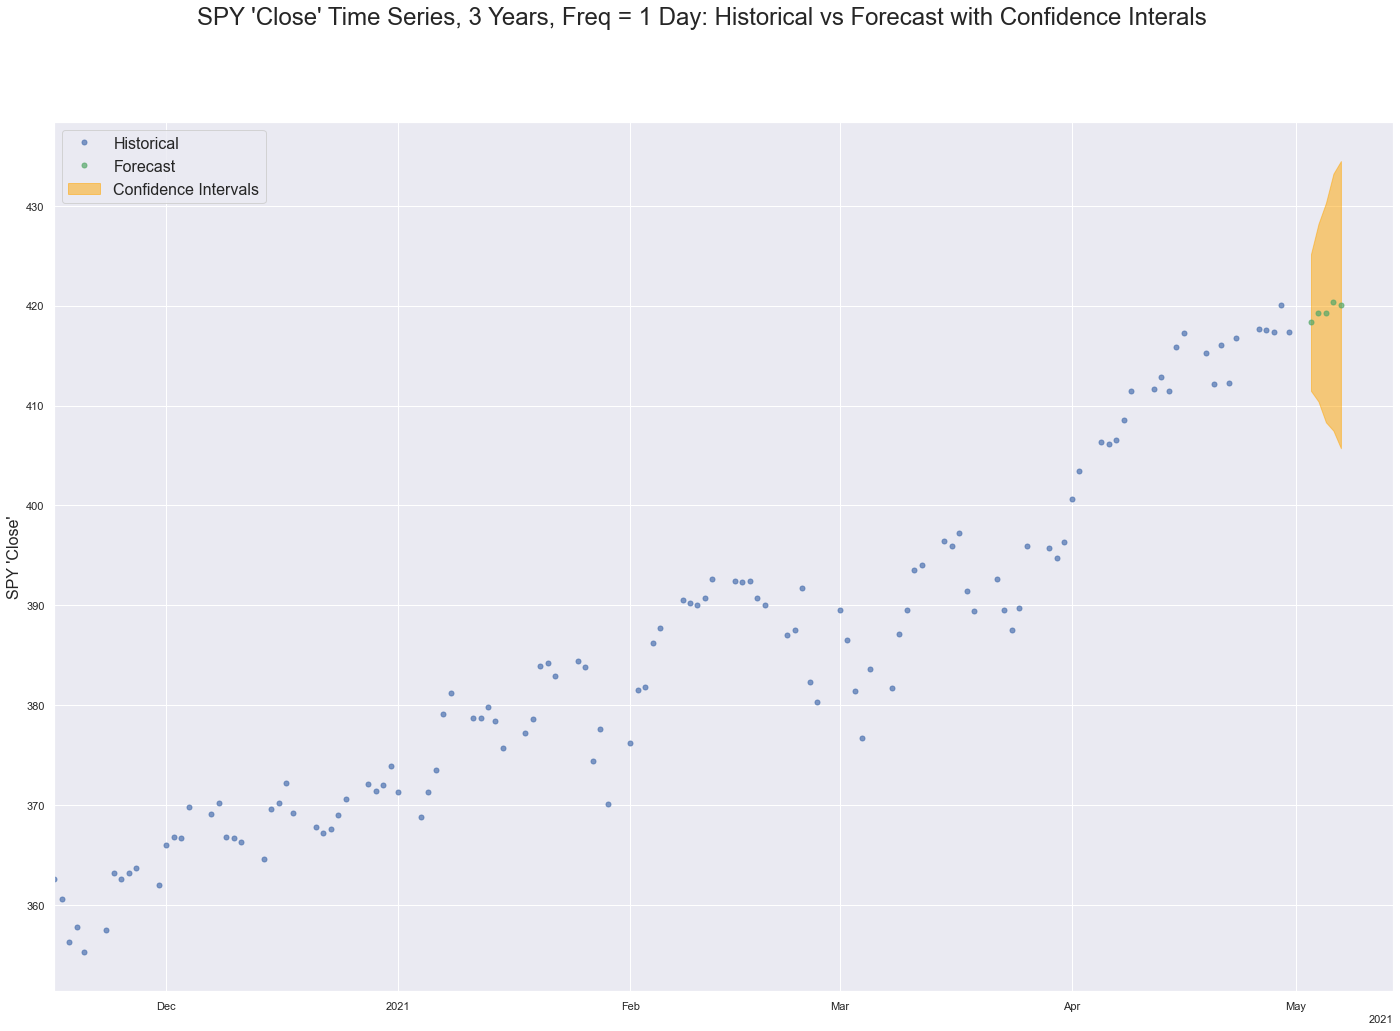

In [865]:
fig, ax = plt.subplots(figsize=(24, 16))
ax.plot(df_full_3Y_close[-120:], 'b.', markersize=10, alpha=0.7, label='Historical')
ax.plot(new_dates_df.date, close_vol_hat, 'g.', markersize=10, alpha=0.7, label='Forecast')
ax.set_xlim(df_full_3Y_close[-120:-119].index,new_dates_df.date[-1:]+5*cbd)
conf_int = np.asarray(close_vol_conf_ints)
ax.fill_between(new_dates_df.date,
         conf_int[:, 0], conf_int[:, 1],
         alpha=0.5, color='orange',
         label="Confidence Intervals")
ax.legend(loc='upper left', borderaxespad=0.5, fontsize = 16)
fig.suptitle(f'{ylabel} Time Series, 3 Years, Freq = 1 Day: Historical vs Forecast with Confidence Interals\n', size=24)
ax.set_ylabel(ylabel, size=16)

### Cross-Validation

In [327]:
# cv = pm.model_selection.RollingForecastCV()
cv = pm.model_selection.SlidingWindowForecastCV(window_size=100,step=1)

In [328]:
df_test

date
2020-09-24    323.500000
2020-09-25    328.730011
2020-09-28    334.190002
2020-09-29    332.369995
2020-09-30    334.890015
                 ...    
2021-04-26    417.609985
2021-04-27    417.519989
2021-04-28    417.399994
2021-04-29    420.059998
2021-04-30    417.339996
Freq: C, Name: close, Length: 157, dtype: float64

In [329]:
cv_gen = cv.split(df_train)

In [330]:
next(cv_gen)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 array([100]))

In [239]:
best_arima_2 = best_arima.to_dict()

In [154]:
best_arima.order

(0, 1, 2)

#### Sliding Window

In [267]:
est = pm.ARIMA(order = best_arima.order, intercept=False)
cv = pm.model_selection.SlidingWindowForecastCV(window_size=200, step=1, h=100)
predictions = pm.model_selection.cross_val_predict(
    est, df_full_3Y_close, cv=cv, verbose=1, averaging="median")

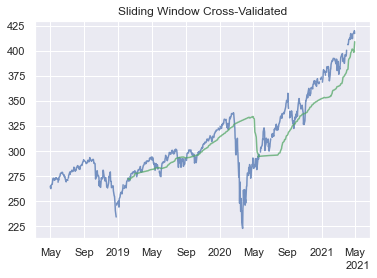

In [268]:
plt.plot(df_full_3Y_close.index, df_full_3Y_close.values, alpha=0.75, c='b')
plt.plot(df_full_3Y_close.index[-predictions.size:], predictions, alpha=0.75, c='g')  # Forecasts
plt.title("Sliding Window Cross-Validated")
plt.show()

#### Rolling

In [341]:
half_index = round(df_full_3Y_close.size/2)

In [592]:
pipe

Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 AutoARIMA(d=1, max_p=0, max_q=0, seasonal=False, start_p=0,
                           start_q=0, trace=3))])

In [375]:
est = pm.ARIMA(order = best_arima.order, intercept=False)
# est = pipe
# cannot use pipeline
cv = pm.model_selection.RollingForecastCV(initial=half_index)
# cannot return conf_int, even with return_conf_int=True
predictions = pm.model_selection.cross_val_predict(
    est, df_full_3Y_close.interpolate(), cv=cv, verbose=1, averaging="median")


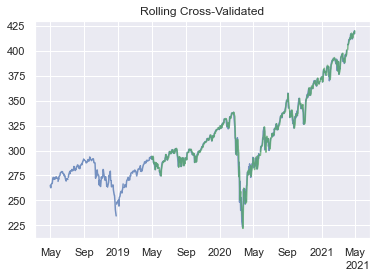

In [332]:
plt.plot(df_full_3Y_close.index, df_full_3Y_close.values, alpha=0.75, c='b')
plt.plot(df_full_3Y_close.index[-predictions.size:], predictions, alpha=0.75, c='g')  # Forecasts
plt.title("Rolling Cross-Validated")
plt.show()

In [346]:
rmse = mse(df_full_3Y_close.interpolate()[-predictions.size:], predictions)

In [347]:
rmse

24.868393035252247

In [379]:
best_arimas

NameError: name 'best_arimas' is not defined

In [377]:
best_params = 'ARIMA Order()'

Pmdarima_Model.py loaded.


In [385]:
best_params.replace('()', str(best_arima.order))

'ARIMA Order(0, 1, 0)'

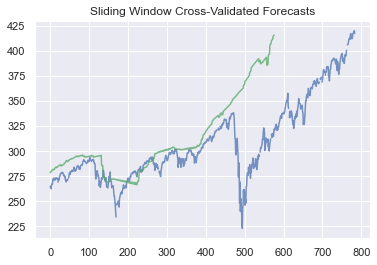

In [212]:
plt.plot(df_full_3Y_close.values, alpha=0.75, c='b')
plt.plot(predictions, alpha=0.75, c='g')  # Forecasts
plt.title("Sliding Window Cross-Validated Forecasts")
plt.show()

### Manual Run

In [153]:
pipe.named_steps['arima'].model_.get_params()

ARIMA(order=(0, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [35]:
y_train.mean()

292.35287041185006

In [33]:
train, test = train_test_split_data(df_full_3Y_close.interpolate(), 80, verbose=1)

##### Train-Test Split #####
Using a 80/20 train-test split...


In [392]:
df_full_3Y_close

date
2018-05-01    264.980011
2018-05-02    263.200012
2018-05-03    262.619995
2018-05-04    266.019989
2018-05-07    266.920013
                 ...    
2021-04-26    417.609985
2021-04-27    417.519989
2021-04-28    417.399994
2021-04-29    420.059998
2021-04-30    417.339996
Freq: C, Name: close, Length: 784, dtype: float64

In [732]:
train, test = pm.model_selection.train_test_split(df_full_3Y_close, train_size=80/100)

In [733]:
X_train = pd.DataFrame(train.index)
y_train = train.values
# X_test = pd.DataFrame(test.index)
X_test = pd.DataFrame(test.index, index=range(X_train.size, pam_3Y.length))
y_test = test.values

X_test

In [740]:
train, test = pm.model_selection.train_test_split(df_full_3Y_vol, train_size=80/100)
X_train = pd.DataFrame(train.index)
y_train = train.values
# X_test = pd.DataFrame(test.index)
X_test = pd.DataFrame(test.index, index=range(X_train.size, pam_3Y.length))
y_test = test.values

In [57]:
date_feat = pm.preprocessing.DateFeaturizer(
    column_name="date",  # the name of the date feature in the X matrix
    with_day_of_week=True,
    with_day_of_month=True)
_, X_train_feats = date_feat.fit_transform(y_train, X_train)

In [665]:
pipe = pipeline.Pipeline([
    ('date', date_feat),
    #                 ("fourier", pm.preprocessing.FourierFeaturizer(m=261, k=4)),
    ('arima', pm.arima.AutoARIMA(d=1,
                                 start_p=0,
                                 start_q=0,
                                 max_p=0,
                                 min_p=0,
                                 max_q=0,
                                 trace=3,
                                 stepwise=True,
                                 suppress_warnings=True,
                                 seasonal=False))
])

In [666]:
pipe.fit(y_train, X_train)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3554.128, Time=0.11 sec
First viable model found (3554.128)
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3552.450, Time=0.42 sec
New best model found (3552.450 < 3554.128)

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.529 seconds


Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 AutoARIMA(d=1, max_p=0, max_q=0, seasonal=False, start_p=0,
                           start_q=0, trace=3))])

NameError: name 'timeframe' is not defined

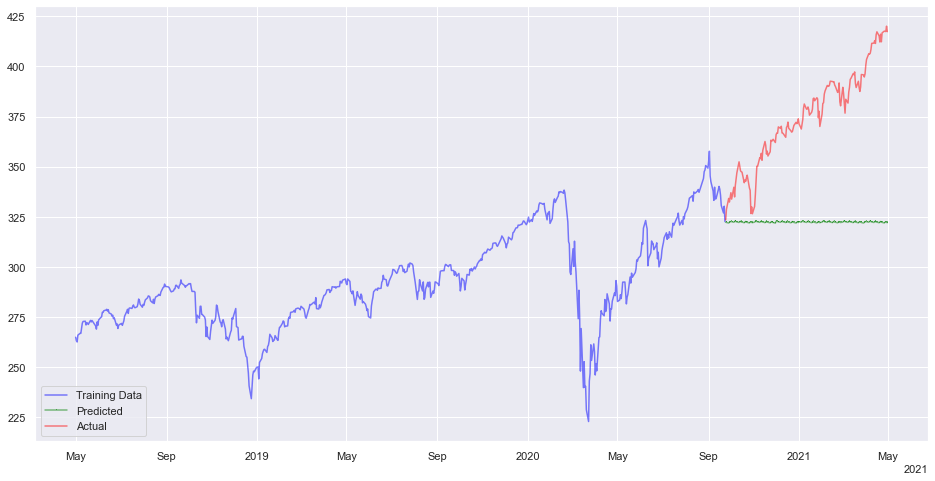

In [476]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(X_train, y_train, color='blue', alpha=0.5, label='Training Data')
ax.plot(X_test, y_hat, color='green', marker=',', alpha=0.5, label='Predicted')
ax.plot(X_test, y_test, color='red', alpha=0.5, label='Actual')
ax.legend(loc='lower left', borderaxespad=0.5)
fig.suptitle(f'{ylabel} Time Series, {timeframe}, Freq = {freq}: Test vs Predict\n', size=18)
ax.set_title(f'Parameters: {params}', size=16)
ax.set_ylabel(ylabel, size=14)

In [380]:
best_arima = pipe.named_steps['arima'].model_

### Test out Stepwise CV

In [675]:
y_hat, conf_ints = pipe.predict(X=X_test, return_conf_int=True)

In [677]:
date = X_test.iloc[0].date + cbd
date

Timestamp('2020-09-25 00:00:00')

In [655]:
date = pd.DataFrame([X_test.iloc[0].date], columns=['date'])
date.date

Pmdarima_Model.py loaded.


0   2020-09-24
Name: date, dtype: datetime64[ns]

In [709]:
%timeit date_df = pd.DataFrame([X_test.iloc[0].date + cbd], index=[X_train.size], columns=['date'])

544 µs ± 111 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [714]:
%timeit date_df = pd.DataFrame([X_test.iloc[0].date + cbd], index=[X_train.size+10], columns=['date'])

532 µs ± 106 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [704]:
%timeit date_df.iloc[0].date += cbd

290 µs ± 104 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [705]:
%timeit date_df.index += 1

295 µs ± 54.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [706]:
date_df

,date
8741,2082-12-08


In [670]:
X_test.iloc[0].date

Pmdarima_Model.py loaded.


Timestamp('2020-09-24 00:00:00')

In [678]:
date = X_test.iloc[0].date
date

Timestamp('2020-09-24 00:00:00')

In [686]:
X_train.size

8.13 µs ± 770 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [683]:
X_train

,date
0,2018-05-01
1,2018-05-02
2,2018-05-03
3,2018-05-04
4,2018-05-07
...,...
622,2020-09-17
623,2020-09-18
624,2020-09-21
625,2020-09-22


In [680]:
y_hat, conf_ints = pipe.predict(X=[date], return_conf_int=True)

TypeError: float() argument must be a string or a number, not 'Timestamp'

In [668]:
y_hat

array([322.30643048])

In [588]:
y_hat2, conf_ints = pipe.predict(X=X_test[0:1] + cbd, return_conf_int=True)

In [615]:
%timeit X_test.iloc[0].date + cbd

159 µs ± 16 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [591]:
(y_hat == y_hat2).sum()

157

In [622]:
y = [10, 2, 3, 4, 5, 6, 7]

In [623]:
for i, count in enumerate(y):
    print (i, count)

0 10
1 2
2 3
3 4
4 5
5 6
6 7


In [455]:
type(conf_ints)

numpy.ndarray

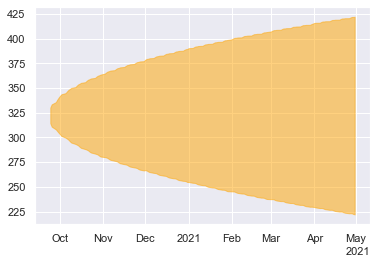

In [440]:
fig, ax = plt.subplots()
ax.fill_between(X_test.date,
               conf_int[:, 0], conf_int[:, 1],
               alpha=0.5, color='orange',
               label="Confidence Intervals")

Pmdarima_Model.py loaded.


Text(0, 0.5, "SPY 'Close'")

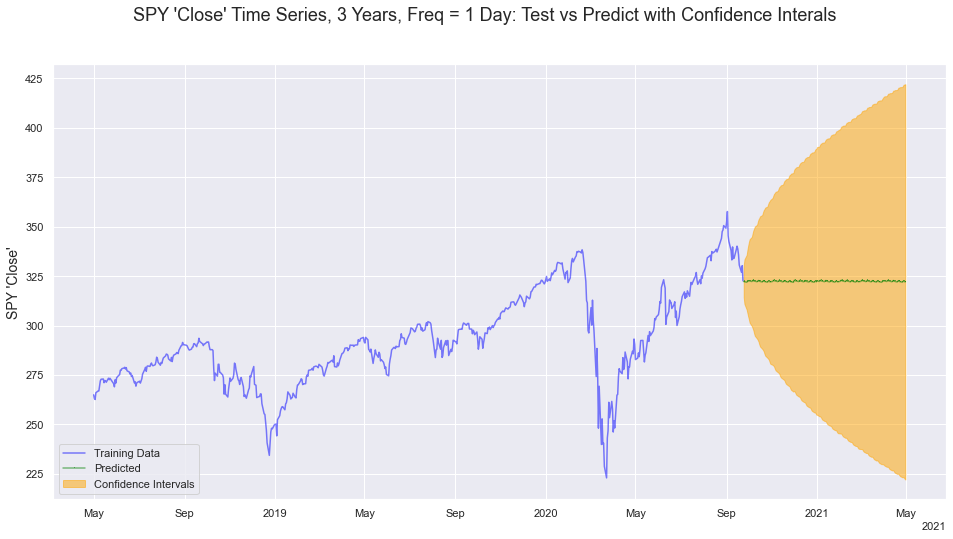

In [441]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(X_train, y_train, color='blue', alpha=0.5, label='Training Data')
ax.plot(X_test, y_hat, color='green', marker=',', alpha=0.5, label='Predicted')
conf_int = np.asarray(conf_ints)
ax.fill_between(X_test.date,
         conf_int[:, 0], conf_int[:, 1],
         alpha=0.5, color='orange',
         label="Confidence Intervals")
ax.legend(loc='lower left', borderaxespad=0.5)
fig.suptitle(f'{ylabel} Time Series, 3 Years, Freq = 1 Day: Test vs Predict with Confidence Interals\n', size=18)
ax.set_ylabel(ylabel, size=14)

In [447]:
conf_int = np.asarray(conf_ints)

In [381]:
best_arima

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [382]:
best_arima.order

(0, 1, 0)

In [105]:
best_arima.model_.fit(train)

ARIMA(order=(0, 1, 2), scoring_args={}, with_intercept=False)

In [ ]:
df_train, df_test = train_test_split_data(df_full_3Y_close, 80, verbose=1)

In [109]:
pipe

Pmdarima_Model.py loaded.


Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 AutoARIMA(d=1, seasonal=False, suppress_warnings=False,
                           trace=3))])

In [547]:
mod = SARIMAX(df_train, order=(0,1,2))

In [548]:
mod.start_params

array([-0.19366851,  0.19684047, 16.60013925])

In [546]:
sari_mod_close = SARIMAX(df_train, order=(0,1,2)).fit()
sari_mod_close.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                  627
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -1698.352
Date:                Mon, 03 May 2021   AIC                           3402.704
Time:                        01:58:38   BIC                           3416.022
Sample:                    05-01-2018   HQIC                          3407.879
                         - 09-23-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2069      0.019    -10.982      0.000      -0.244      -0.170
ma.L2          0.2255      0.018     12.861      0.000       0.191       0.260
sigma2        15.8649      0.362     43.782      0.000      15.155      16.575
===================================================================================
Ljung-Box (Q):                      101.38   Jarque-Bera (JB):              3544.19
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.81   Skew:                            -1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
sari_mod_close.

In [ ]:
sari_mod_close = SARIMAX(df_train, order=(0,1,2), seasonal_order=(0,1,2,261)).fit()
sari_mod_close.summary()

In [ ]:
y_hat_train = sari_mod_close.predict(typ='levels', dynamic=False)
y_hat_test = sari_mod_close.predict(start=df_test.index[0], end=df_test.index[-1], typ='levels')

In [ ]:
y_hat_test

In [ ]:
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(df_train, label='Train')
ax.plot(df_test, label='Test')
ax.plot(y_hat_train[1:], label='Train Predictions')
ax.plot(y_hat_test, label='Test Predictions')
ax.set_title('SPY Close Price: Train/Test v Predictions In-Sample')
plt.setp(ax.xaxis.get_majorticklabels(), ha="right", rotation=45, rotation_mode="anchor")
plt.legend()

## Last 5 Years, 1 Day

In [ ]:
pam_3Y = Pmdarima_Model(df_full_3Y_close, df_full_3Y_vol, 'SPY \'Close\'', 'SPY \'Volume\'',
               n=3, period='years', freq='1 Day', seas=261, fit_seas=False,
               train_size=80, impute=0, verbose=1,
               date=1, fourier=1, box=0, log=0, gridsearch=0)

In [ ]:
df_train, df_test, vol_train, vol_test = pdarima_fit_predict(df_full_5Y_close, df_full_5Y_vol, 'SPY \'Close\'', 'SPY \'Volume\'',
                                                             n=5, period='years', freq='1 Day', seas=261,
                                                             train_size=80, impute=1, verbose=1, extra=1)

## Last 10 Years, 1 Day

In [1088]:
pam_10Y = Pmdarima_Model(df_full_10Y_close, df_full_10Y_vol, 'SPY \'Close\'', 'SPY \'Volume\'',
               n=10, period='years', freq='1 Day', seas=261, fit_seas=False,
               train_size=80, impute=0, verbose=1,
               date=1, fourier=1, box=0, log=0, gridsearch=0)

Successfully created instance of Class Pmdarima_Model.


Starting AutoARIMA...
Endogenous data set diffs to use: 1


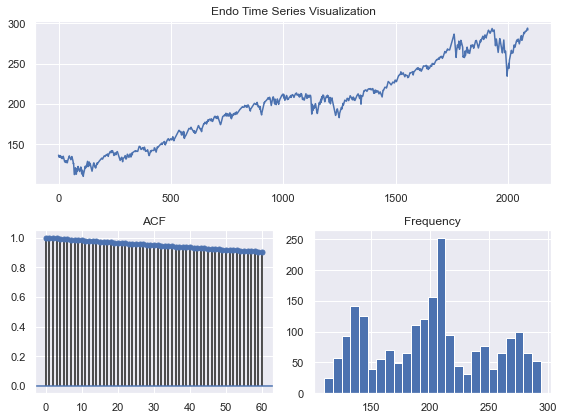

Using DateFeaturizer.
Using FourierFeaturizer.
Parameters for Pipeline: 
[('date', DateFeaturizer(column_name='date')), ('fourier', FourierFeaturizer(k=4, m=261)), ('arima', AutoARIMA(d=1, maxiter=200, seasonal=False, trace=3))]

Performing stepwise search to minimize aic
Near non-invertible roots for order (2, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=17.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8165.399, Time=0.61 sec
First viable model found (8165.399)
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8167.399, Time=1.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8167.399, Time=1.67 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8167.418, Time=1.63 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8168.957, Time=5.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 27.639 seconds
Test AIC: 8165.40
Test RMSE: 35.50
This is 17.70% of the avg ob

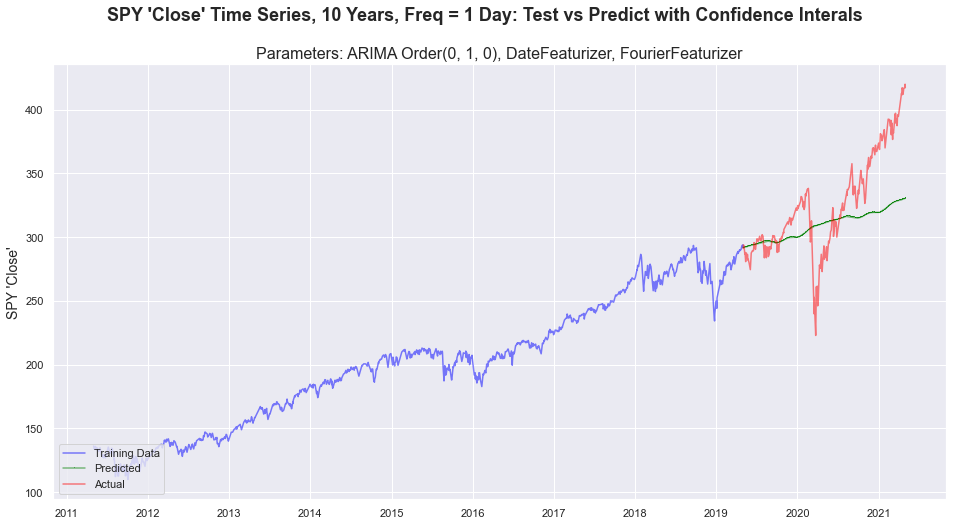

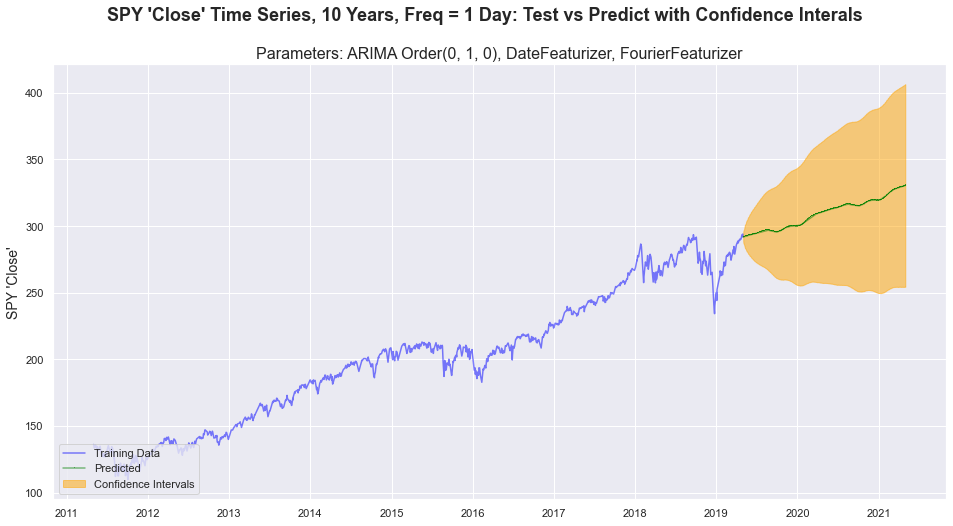

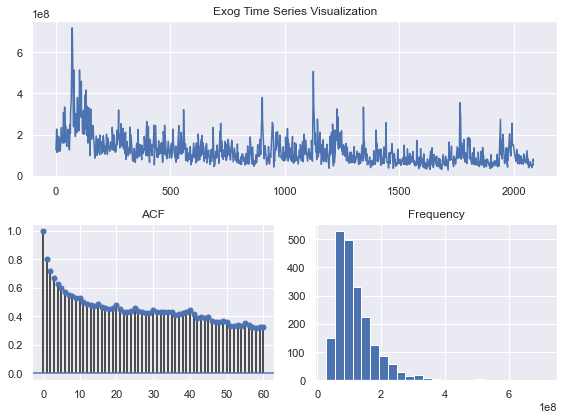

Using DateFeaturizer.
Using FourierFeaturizer.
Parameters for Pipeline: 
[('date', DateFeaturizer(column_name='date')), ('fourier', FourierFeaturizer(k=4, m=261)), ('arima', AutoARIMA(d=0, maxiter=200, seasonal=False, trace=3))]

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=78778.738, Time=6.02 sec
First viable model found (78778.738)
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=95036.117, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=78968.686, Time=0.51 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=80163.579, Time=0.76 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=78818.569, Time=2.48 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=78796.676, Time=3.15 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=78779.628, Time=24.51 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=78779.088, Time=7.34 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=78840.165, Time=1.71 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=78815.507, Time=3.32 sec
 ARIMA(3,0,1)(0,0,0

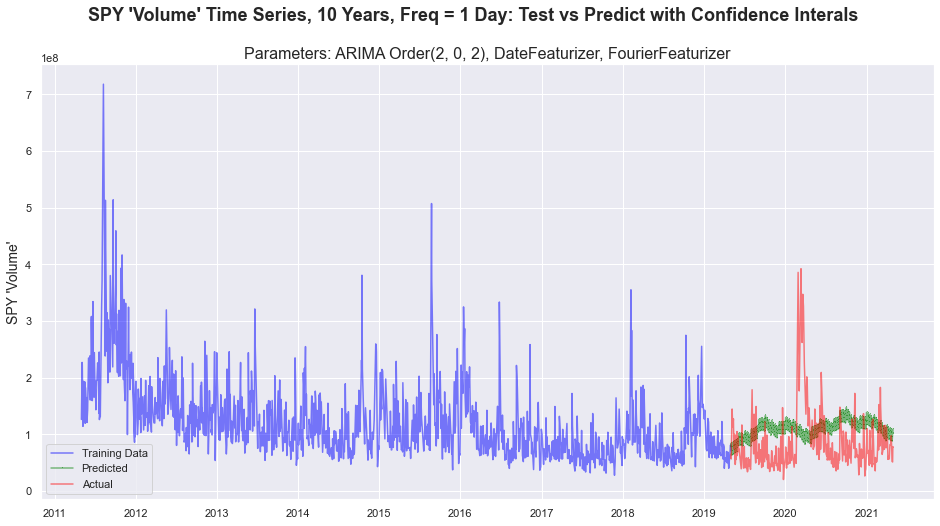

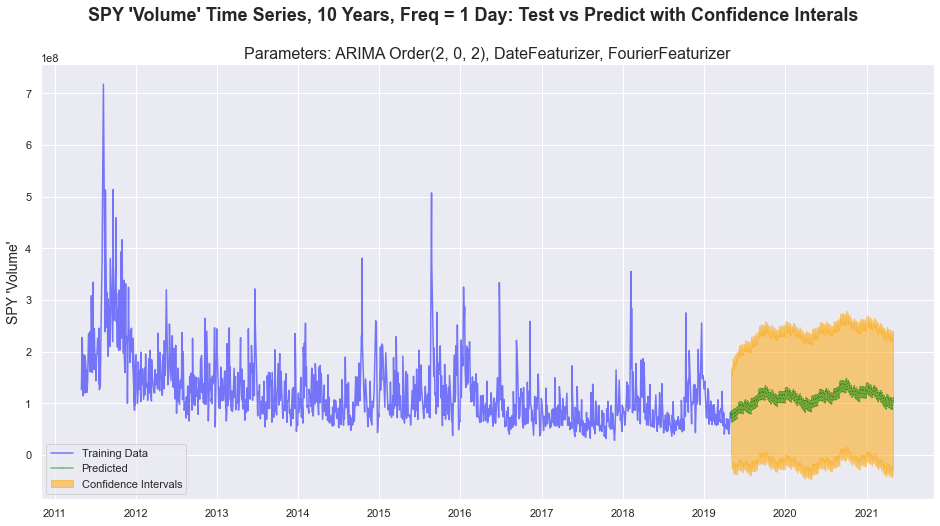

In [1089]:
endo_pipe, exog_pipe = pam_10Y.run_auto_pipeline(en=True, ex=True, visualize=True)

In [1091]:
pam_10Y_vol = exog_pipe

In [1092]:
vol_hat, vol_conf_ints = pam_10Y_vol.predict(X=new_dates_df, return_conf_int=True)
vol_hat

array([62777972.60637993, 69756032.35173792, 76611504.69029722,
       79042975.77198942, 85268863.54886658])

In [1093]:
vol_hat_df = pd.DataFrame(vol_hat, index=index_fc, columns=['volume'])
vol_hat_df = vol_hat_df.join(new_dates_df)
vol_hat_df

,volume,date
784,6.277797e+07,2021-05-03
785,6.975603e+07,2021-05-04
786,7.661150e+07,2021-05-05
787,7.904298e+07,2021-05-06
788,8.526886e+07,2021-05-07


In [1094]:
train, test = pm.model_selection.train_test_split(df_full_10Y_close, train_size=80/100)
X_train = pd.DataFrame(train.index)
y_train = train.values
# X_test = pd.DataFrame(test.index)
X_test = pd.DataFrame(test.index, index=range(X_train.size, pam_10Y.length))
y_test = test.values

X_test

,date
2088,2019-05-02
2089,2019-05-03
2090,2019-05-06
2091,2019-05-07
2092,2019-05-08
...,...
2605,2021-04-26
2606,2021-04-27
2607,2021-04-28
2608,2021-04-29


In [1095]:
date_feat = pm.preprocessing.DateFeaturizer(
    column_name="date",  # the name of the date feature in the X matrix
    with_day_of_week=True,
    with_day_of_month=True)
_, X_train_feats = date_feat.fit_transform(y_train, X_train)
full_10Y_pipe = pipeline.Pipeline([
    ('date', date_feat),
    ("fourier", pm.preprocessing.FourierFeaturizer(m=261, k=4)),
    ('arima', pm.arima.AutoARIMA(d=1,
                                 trace=3,
                                 stepwise=True,
                                 suppress_warnings=True,
                                 seasonal=False))
])

In [1096]:
vol_10Y_df = pd.DataFrame(df_full_10Y_vol).reset_index()

In [1097]:
full_10Y_pipe.fit(df_full_10Y_close, vol_10Y_df)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11935.843, Time=4.63 sec
First viable model found (11935.843)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12038.019, Time=2.92 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11956.722, Time=3.85 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11972.383, Time=4.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=29957.461, Time=3.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11937.539, Time=5.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11954.795, Time=5.29 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=11916.226, Time=4.90 sec
New best model found (11916.226 < 11935.843)
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=11939.465, Time=5.42 sec


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1886: RuntimeWarning:

divide by zero encountered in reciprocal

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1893: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=12054.071, Time=5.21 sec


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1886: RuntimeWarning:

divide by zero encountered in reciprocal

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1893: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=12055.447, Time=4.95 sec


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1886: RuntimeWarning:

divide by zero encountered in reciprocal

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1893: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=12053.127, Time=5.19 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=11925.766, Time=5.27 sec


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1886: RuntimeWarning:

divide by zero encountered in reciprocal

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1893: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=12060.639, Time=5.66 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=11917.508, Time=5.30 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0] intercept
Total fit time: 71.021 seconds


Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima', AutoARIMA(d=1, seasonal=False, trace=3))])

In [1098]:
close_vol_hat, close_vol_conf_ints = full_10Y_pipe.predict(X=vol_hat_df, return_conf_int=True)
close_vol_hat

array([418.34988293, 418.51239131, 418.55684762, 418.9033956 ,
       418.81211565])

### Plot

In [1100]:
new_fc_df = pd.DataFrame(zip(new_dates_df.date.values,close_vol_hat), columns=['date','close'])
new_fc_df.set_index('date', inplace=True)

In [1101]:
spy_df_10Y_fc = spy_df_10Y.append(new_fc_df)

Text(0.5, 0.98, "SPY 'Close' Time Series, 10 Years, Freq = 1 Day: Historical vs Forecast with Confidence Interals\n")

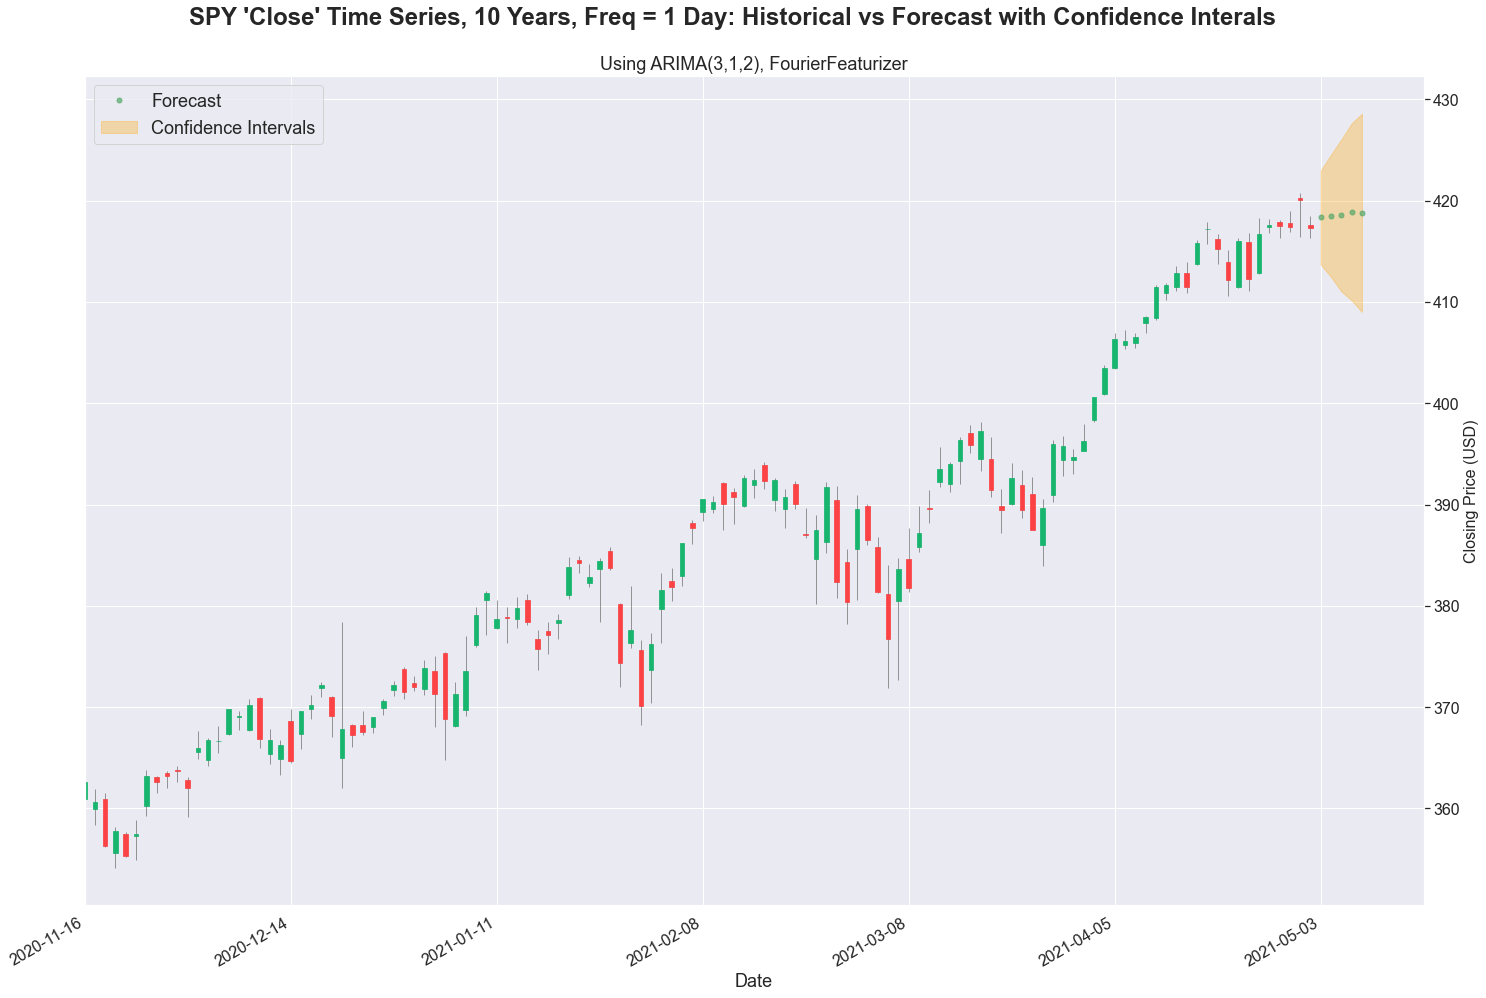

In [1102]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(24, 16))
mpl.plot(spy_df_10Y[-120:],
         type='candle',
         style="yahoo",
         ax=ax,
         )
ax.plot(range(120,125), close_vol_hat, 'g.', markersize=10, alpha=0.7, label='Forecast')
conf_int = np.asarray(close_vol_conf_ints)
ax.fill_between(range(120,125),
         conf_int[:, 0], conf_int[:, 1],
         alpha=0.3, color='orange',
         label="Confidence Intervals")
ax.set_xlim(0, 130)
ax.set_ylabel('Closing Price (USD)', size=16)
ax.set_title('Using ARIMA(3,1,2), FourierFeaturizer', size=18)
equidate_ax(fig, ax, spy_df_10Y_fc[-125:].index.date)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
fig.subplots_adjust(top=0.92)
ax.legend(loc='upper left', borderaxespad=0.5, fontsize = 18)
fig.suptitle(f'{ylabel} Time Series, 10 Years, Freq = 1 Day: Historical vs Forecast with Confidence Interals\n', size=24)

### Stepwise Predictions

In [1112]:
date_feat = pm.preprocessing.DateFeaturizer(
    column_name="date",  # the name of the date feature in the X matrix
    with_day_of_week=True,
    with_day_of_month=True)
_, X_train_feats = date_feat.fit_transform(y_train, X_train)
full_10Y_pipe = pipeline.Pipeline([
    ('date', date_feat),
    ("fourier", pm.preprocessing.FourierFeaturizer(m=261, k=4)),
    ('arima', pm.arima.AutoARIMA(d=1,
                                 trace=3,
                                 stepwise=True,
                                 suppress_warnings=True,
                                 seasonal=False))
])

In [1115]:
full_10Y_pipe.fit(df_full_10Y_close.values, pd.DataFrame(df_full_10Y_close.index))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12214.689, Time=6.64 sec
First viable model found (12214.689)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12294.972, Time=0.57 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12237.227, Time=0.74 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12247.158, Time=1.74 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12297.692, Time=2.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=12215.559, Time=3.45 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12219.952, Time=4.43 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=12127.281, Time=10.39 sec
New best model found (12127.281 < 12214.689)
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=12161.384, Time=6.42 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=12156.903, Time=12.72 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=12200.066, Time=12.53 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=12203.654, Time=13.39 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=12208.685, Time=10.81 sec

Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima', AutoARIMA(d=1, seasonal=False, trace=3))])

In [1116]:
model = full_10Y_pipe
dynamic = False
def forecast_one_step(date_df):
    fc, conf_int = model.predict(X=date_df, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

date_df = pd.DataFrame([df_full_10Y_close.index[0]], columns=['date'])
forecasts = []
conf_ints = []
print(f'Iteratively making predictions on SPY \'Close\' Time Series and updating model, beginning at 0 ...', end='')
for new_ob in df_full_10Y_close:
    fc, conf = forecast_one_step(date_df)
    forecasts.append(fc)
    conf_ints.append(conf)

    # Updates the existing model with a small number of MLE steps
    if dynamic == True:
        model.update([fc], date_df)
    elif dynamic == False:
        model.update([new_ob], date_df)
    print('.', end='')
    # date = pd.DataFrame([X_test.iloc[0].date + cbd], index=[X_train.size]columns=['date'])
    date_df.iloc[0].date += cbd
    date_df.index += 1
    # date += cbd
print(' Done.')
# y_hat = pd.Series(forecasts, index=y_test.index)
y_hat = forecasts

Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning at 0 ...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [1122]:
y_test

array([291.17999268, 294.02999878, 292.82000732, 287.92999268,
       287.52999878, 286.66000366, 288.1000061 , 280.85998535,
       283.3999939 , 285.05999756, 287.70001221, 285.83999634,
       283.95001221, 286.51000977, 285.63000488, 282.14001465,
       282.77999878, 281.46499634, 280.1499939 , 278.26998901,
       279.02999878, 275.26998901, 274.57000732, 280.52999878,
       282.95999146, 284.79998779, 287.6499939 , 288.97000122,
       288.8999939 , 288.39001465, 289.57998657, 289.26000977,
       289.36999512, 292.3999939 , 293.05999756, 295.85998535,
       294.        , 293.64001465, 290.76000977, 290.47000122,
       291.5       , 293.        , 295.66000366, 296.42999268,
       298.79998779, 298.62998962, 298.45999146, 296.82000732,
       297.19000244, 298.60998535, 299.30999756, 300.6499939 ,
       300.75      , 299.77999878, 297.73999023, 298.82998657,
       297.17001343, 297.8999939 , 300.02999878, 301.44000244,
       300.        , 302.01000977, 301.45999146, 300.72

In [1124]:
RMSE = mse(df_full_10Y_close, y_hat, squared=False)
print("Test RMSE: %.2f" % RMSE)
print("This is %.2f%% of the avg observed value." % (100*RMSE/y_train.mean()))
print("Test SMAPE: %.2f%%\n" % smape(df_full_10Y_close, y_hat))

Test RMSE: 6.11
This is 3.05% of the avg observed value.
Test SMAPE: 0.77%



In [1125]:
fc, conf_ints = model.predict(X=new_dates_df, return_conf_int=True)

In [1126]:
fc

array([415.79375328, 416.02634351, 415.59837954, 415.64020693,
       415.15920983])

In [1128]:
conf_int

array([[406.74593906, 424.84156751],
       [403.41457578, 428.63811125],
       [400.08295467, 431.11380441],
       [397.68858214, 433.59183173],
       [395.1457591 , 435.17266056]])

In [1127]:
Audio(sound_file, autoplay=True)

In [ ]:
df_train, df_test, vol_train, vol_test = pdarima_fit_predict(df_full_10Y_close, df_full_10Y_vol, 'SPY \'Close\'', 'SPY \'Volume\'',
                                                             n=10, period='years', freq='1 Day', seas=261,
                                                             train_size=80, impute=1, verbose=1, extra=1)

In [ ]:
y, X = load_date_example()
y_train, y_test, X_train, X_test = \
    pm.model_selection.train_test_split(y, X, test_size=20)

In [ ]:
df_full_10Y_close.isna().sum()

### Manual

In [70]:
# df_train, df_test = train_test_split_data(df_full_10Y_close, 80, verbose=1)
df_train, df_test = train_test_split_data(df_full_3Y_close, 80, verbose=1)

##### Train-Test Split #####
Using a 80/20 train-test split...


In [71]:
df_train.interpolate()

date
2018-05-01    264.980011
2018-05-02    263.200012
2018-05-03    262.619995
2018-05-04    266.019989
2018-05-07    266.920013
                 ...    
2020-09-17    335.839996
2020-09-18    330.649994
2020-09-21    326.970001
2020-09-22    330.299988
2020-09-23    322.640015
Freq: C, Name: close, Length: 627, dtype: float64

In [72]:
new_mod = pm.auto_arima(df_train.interpolate())

In [73]:
new_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  627
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -1743.415
Date:                Sun, 02 May 2021   AIC                           3492.831
Time:                        14:18:32   BIC                           3506.149
Sample:                             0   HQIC                          3498.006
                                - 627                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1913      0.018    -10.648      0.000      -0.227      -0.156
ma.L2          0.2227      0.017     13.271      0.000       0.190       0.256
sigma2        15.3626      0.340     45.177      0.000      14.696      16.029
===================================================================================
Ljung-Box (Q):                      102.37   Jarque-Bera (JB):              3486.68
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.80   Skew:                            -1.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [74]:
new_mod.fit(df_train.interpolate())

ARIMA(order=(0, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [75]:
new_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  627
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -1743.415
Date:                Sun, 02 May 2021   AIC                           3492.831
Time:                        14:18:49   BIC                           3506.149
Sample:                             0   HQIC                          3498.006
                                - 627                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1913      0.018    -10.648      0.000      -0.227      -0.156
ma.L2          0.2227      0.017     13.271      0.000       0.190       0.256
sigma2        15.3626      0.340     45.177      0.000      14.696      16.029
===================================================================================
Ljung-Box (Q):                      102.37   Jarque-Bera (JB):              3486.68
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.80   Skew:                            -1.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
y_hat_train, conf_int_train = new_mod.predict(typ='levels', dynamic=False, return_conf_int=True)
y_hat_test, conf_int_test = new_mod.predict(start=df_test.index[0], end=df_test.index[-1], typ='levels', return_conf_int=True)

In [ ]:
y_hat_test

In [ ]:
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(df_train, label='Train')
ax.plot(df_test, label='Test')
ax.plot(y_hat_train[1:], label='Train Predictions')
ax.plot(y_hat_test, label='Test Predictions')
ax.set_title('SPY Close Price: Train/Test v Predictions In-Sample')
plt.setp(ax.xaxis.get_majorticklabels(), ha="right", rotation=45, rotation_mode="anchor")
plt.legend()

## Last 5 Days, 1min

In [ ]:
data = pm.datasets.load_wineind()
train, test = pm.model_selection.train_test_split(data, train_size=150)

In [ ]:
test

In [ ]:
# round((80/100)*len(df))

In [ ]:
# df_train, df_test = train_test_split_data(df, 80)
df_train_last_5d_1min, df_test_last_5d_1min = train_test_split_data(df_last_5d_1min_close, 80)
vol_train_last_5d_1min, vol_test_last_5d_1min = train_test_split_data(vol_last_5d_1min, 80)

#### No Seasonality

In [ ]:
# Train Set
pm.auto_arima(vol_train_last_5d_1min.dropna()).summary()

In [ ]:
# Full Set
pm.auto_arima(vol_last_5d_1min.dropna()).summary()

#### 1 Day Seasonality

##### Train Set

In [ ]:
# pm.auto_arima(vol_train_last_5d_1min.dropna(), seasonal=True, m=24*60).summary()

##### Full Set

In [ ]:
# pm.auto_arima(vol_last_5d_1min.dropna(), seasonal=True, m=24*60).summary()

In [ ]:
# param_list = []
# param_seasonal_list = []
# aic_list = []

In [ ]:
# param = (2,1,0)
# param_seasonal = (2,1,0,2190)

In [ ]:
# mod = SARIMAX(df_train,
#               order=param,
#               seasonal_order=param_seasonal,
#               enforce_stationarity=False,
#               enforce_invertibility=False,
#               verbose=True).fit()
# param_list.append(param)
# param_seasonal_list.append(param_seasonal)
# aic = mod.aic

In [ ]:
# param_list, param_seasonal_list, aic_list = gridsearch_SARIMAX(df_train)

## Auto ARIMA

In [ ]:
# pm.auto_arima(df.dropna(), seasonal=True, m=2190).summary()
# pm.auto_arima(df.dropna(), seasonal=True, m=round(365/4)).summary()

### Last 5 Days, 1min - `Close`

In [ ]:
# Train Set
# pm.auto_arima(df_train_last_5d_1min.dropna(), exog=vol_train_last_5d_1min).summary()

In [ ]:
# Full Set
pm.auto_arima(df_last_5d_1min_close.dropna(), exog=vol_last_5d_1min).summary()

#### 1 Day Seasonality

##### Train Set

In [ ]:
# pm.auto_arima(df_train_last_5d_1min.dropna(), exog=vol_train_last_5d_1min, seasonal=True, m=24*60).summary()

##### Full Set

In [ ]:
# pm.auto_arima(df_last_5d_1min.dropna(), exog=vol_last_5d_1min, seasonal=True, m=24*60).summary()

In [ ]:
# pm.auto_arima(df_last_5d_1min_close.dropna(), exog=vol_last_5d_1min, exog=vol_train, seasonal=True, m=16*5).summary()

## SARIMAX Fitting

In [ ]:
df_test_last_5d_1min

In [ ]:
df_train_last_5d_1min.isna().index

In [ ]:
df_test_last_5d_1min

### Last 5 Days, Freq = Minute

#### No Seasonality

In [ ]:
# sari_mod_volume = SARIMAX(vol_train_last_5d_1min, order=(4,1,5)).fit()
# sari_mod_volume.summary()
# failed to converge

In [ ]:
sari_mod_volume = SARIMAX(vol_train_last_5d_1min, order=(4,1,5)).fit()
sari_mod_volume.summary()

In [ ]:
sari_mod_close = SARIMAX(df_train_last_5d_1min, order=(1,1,3), exog=vol_train_last_5d_1min.dropna()).fit()
sari_mod_close.summary()

#### 1 Day Seasonality

In [ ]:
# sari_mod_volume = SARIMAX(vol_train_last_5d_1min, order=(1,1,0),seasonal_order=(1,1,0,24*60)).fit()
# sari_mod_volume.summary()

In [ ]:
# sari_mod_close = SARIMAX(df_train_last_5d_1min, order=(1,1,0), exog=vol_train_last_5d_1min.dropna(), seasonal_order=(1,1,0,24*60)).fit()
# sari_mod_close.summary()

In [ ]:
df_test_last_5d_1min.index[0]

## Simple Test vs Predict

### Last 5 Days, 1min - `Volume`

#### No Seasonality

In [ ]:
v_hat_train_last_5d_1min = sari_mod_close.predict(typ='levels', dynamic=False)
v_hat_test_last_5d_1min = sari_mod_close.predict(start=vol_test_last_5d_1min.index[0], end=vol_test_last_5d_1min.index[-1], typ='levels')

### Last 5 Days, 1min - `Close`

In [ ]:
y_hat_train_last_5d_1min = sari_mod_close.predict(typ='levels', dynamic=False)
y_hat_test_last_5d_1min = sari_mod_close.predict(start=df_test_last_5d_1min.index[0], end=df_test_last_5d_1min.index[-1], typ='levels')

#### 1 Day Seasonality

### Visualization

In [ ]:
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(df_train_last_5d_1min, label='Train')
ax.plot(df_test_last_5d_1min, label='Test')
ax.plot(y_hat_train_last_5d_1min, label='Train Predictions')
ax.plot(y_hat_test_last_5d_1min, label='Test Predictions')
ax.set_title('SPY Close Price: Train/Test v Predictions In-Sample')
plt.setp(ax.xaxis.get_majorticklabels(), ha="right", rotation=45, rotation_mode="anchor")
plt.legend()

In [ ]:
# fig, ax = plt.subplots(figsize = (10,8))
# ax.plot(df_train_last_5d_1min, label='Train')
# ax.plot(df_test_last_5d_1min, label='Test')
# ax.plot(y_hat_train_last_5d_1min, label='Train Predictions')
# ax.plot(y_hat_test_last_5d_1min, label='Test Predictions')
# ax.set_title('SPY Close Price: Train/Test v Predictions In-Sample')
# plt.setp(ax.xaxis.get_majorticklabels(), ha="right", rotation=45, rotation_mode="anchor")
# plt.legend()

In [ ]:
y_hat_train.idxmax()

In [ ]:
y_hat_train.max()

In [ ]:
y_hat_train.drop(y_hat_train.idxmax(), inplace=True)

In [ ]:
y_hat_test

## SARIMAX Forecasting

### Volume

In [ ]:
sari_mod_vol_fc = SARIMAX(vol_last_5d_1min,order=(4,1,5)).fit()
sari_mod_vol_fc.summary()

In [ ]:
vol_fc = sari_mod_vol_fc.forecast(steps=24*60)
vol_fc
vol_fc.plot()

In [ ]:
vol_last_5d_1min

In [ ]:
vol_cat = vol_last_5d_1min.append(vol_fc)
vol_cat

In [ ]:
df_last_5d_1min_close[df_last_5d_1min_close.isna()].index.size

In [ ]:
vol_cat[vol_cat.isna()].index.size

In [ ]:
df_int = df_last_5d_1min_close.interpolate()
df_int

In [ ]:
vol_int = vol_last_5d_1min.interpolate()
vol_int

### Close

In [ ]:
# exog cannot have NaN
# sari_mod_close_fc = SARIMAX(df_last_5d_1min_close, exog=vol_last_5d_1min, order=(1,1,3)).fit()

sari_mod_close_fc = SARIMAX(df_last_5d_1min_close, exog=vol_last_5d_1min.interpolate(), order=(0,0,0)).fit()
sari_mod_close_fc.summary()

In [ ]:
sari_mod_close_fc = SARIMAX(df_int, exog=vol_int, order=(1,1,3)).fit()
# sari_mod_close_fc = SARIMAX(df_last_5d_1min_close, exog=vol_int, order=(1,1,3)).fit()

In [ ]:
# sari_mod_last = SARIMAX(df_last, order=(1,1,0), seasonal_order=(1,1,0,16)).fit()
# sari_mod_last = SARIMAX(df_last.dropna(), order=(1,1,0), seasonal_order=(1,1,0,16), exog=vol_last.dropna()).fit()
sari_mod_close_fc.summary()

In [ ]:
close_fc = sari_mod_close_fc.forecast(steps=24*60, exog = vol_fc)

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
ax.plot(df_last_5d_1min_close, label='Historical')
ax.plot(close_fc, label='Forecast')
ax.set_title('SPY Prices: 24 Hour Forecast\nusing SARIMAX(1,1,3)')
plt.legend()

## Facebook Prophet

In [ ]:
df_pro = pd.DataFrame(df.reset_index())
df_pro.columns = ['ds','y']

In [ ]:
df_pro

In [ ]:
promod = prophet.Prophet()
promod.fit(df_pro)

In [ ]:
future = promod.make_future_dataframe(periods=16, freq=cbh)
future.tail(32)

In [ ]:
forecast = promod.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
df_pro[-16:]

In [ ]:
forecast[-32:]

In [ ]:
fig, ax = plt.subplots(figsize = (20,15))
promod.plot(forecast, ax=ax);
# start = pd.to_datetime('2021-04-23')
# end = pd.to_datetime('2021-04-26')
# ax.set_xlim(start,end)

In [ ]:
forecast.yhat.plot()

In [ ]:
fig2 = promod.plot_components(forecast)
